#**Directions to access and use this notebook**

### This notebook is split into 4 main sections: Data Collection, Data Analysis, Bias Calibration, and Preliminary Results

1.   Data Collection deals with collecting and processing the buoy and satellite data from their designated Google Drive folders. It produces and stores as csv the processed buoy and satellite arrays of temperature, chlorophyll, and salinity as well as arrays of the dates and cloud cover for all 3 satellite collections. You can download the raw buoy data from this website: https://data-explorer.riddc.brown.edu/dataset/ri-buoy/summary. The satellite data is accessed through Google Earth Engine.

2.   Data Analysis uses these processed arrays to perform the comparison between buoy and satellite temperatures and create an uncalibrated climatology of temperature.

3.   Bias Calibration calculates and corrects the systematic biases in the satellite datasets and creates bias-calibrated plots.

4. Preliminary Results provides our first look into expanding the temperature record and assessing long-term trends.

### Running the code

*   Right below these directions is the block of code needed to run the rest of the notebook. Running this code will prompt you to connect your Google Drive and then connect your Earth Engine account using a link to get the access code. You will need to create a Google Cloud Platform project to connect to Google Earth Engine.

*   The first code block of each section accesses the necessary csv files or numpy arrays to run the remaining blocks of code for each section. Data above a certain cloud cover cutoff value are filtered out in the last 3 sections, and this cloud cutoff value can be changed in the first code block of each section if desired.

In [42]:
### Connects to google drive and installs/imports desired modules, run this
### code every time ###

# Connects to google drive #
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

# Imports #
import numpy as np
import csv
import pandas as pd
from datetime import datetime as dt

# Visualization
from matplotlib import pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
!pip install prettytable
from prettytable import PrettyTable

# Scipy
from scipy import optimize
from scipy.interpolate import make_interp_spline

# Maps
import folium
from folium.features import DivIcon

# Earth Engine
import ee
ee.Authenticate()
ee.Initialize()

Enter verification code: 4/1AbUR2VPiJQQg_jWUwssoyizH9sD36BCOeACjD2nZYcVR_k66nqIphAWYEc8

Successfully saved authorization token.


# Data Collection

In [36]:
%cd ~/Projects/landsat-wexler/


/Users/tdivoll/Projects/landsat-wexler


In [37]:
### Loads all bouy data into one array ###


# Make sure you are in the landsat-wexler repo root folder
# File directory to access the data annd create an array #
fpath = './Data/raw_buoy_data/'
fnames = ["bid2", "bid3", "bid4", "bid5", "bid6", "bid7", "bid8", 
          "bid9", "bid10", "bid13", "bid15", "bid16", "bid17"]
all_buoys = []

# Function that adds the data of a csv file to all_buoys array #
def readCSV(bid):
  count = 0
  file = open(fpath + bid + ".csv")
  csvreader = csv.reader(file)
  data = []
  for row in csvreader:
    if count != 0 and count != 1:
      data.append(row)
    count += 1
  all_buoys.append(data)

# Calls readCSV on every buoy #
for buoy in fnames:
  readCSV(buoy)

# Fills latitude and longituge arrays from data in all_buoys #
lat = []
lon = []
for i in range(len(all_buoys)):
  lat.append(float(all_buoys[i][0][4]))
  lon.append(float(all_buoys[i][0][5]))

In [38]:
#@title Narragansett Bay Geometry (run this code)

NG0 = ee.Geometry.Polygon(
        [[-71.23430897643202, 41.67803448724837],
          [-71.2387115097295, 41.66434415508815],
          [-71.24506298067676, 41.66844770361683],
          [-71.25931087496387, 41.64279623448692],
          [-71.255191001917, 41.63663836177501],
          [-71.23407665255176, 41.63933250348853],
          [-71.2196570968877, 41.65626452960499],
          [-71.21656719210254, 41.639075923415746],
          [-71.21141735079395, 41.63933250348853],
          [-71.20778129628407, 41.65320086118295],
          [-71.19507835438954, 41.68166876899119],
          [-71.17947308941616, 41.69648952647567],
          [-71.17621152325405, 41.69956567534286],
          [-71.17037503643765, 41.7022571849021],
          [-71.16625516339077, 41.70558937398956],
          [-71.17655484600796, 41.7109717761861],
          [-71.17844312115444, 41.70879323910567],
          [-71.18696944419253, 41.71118570860874],
          [-71.18937270346987, 41.71118570860874],
          [-71.18748442832339, 41.71080126753273],
          [-71.1878277510773, 41.708110115624876],
          [-71.19126097861636, 41.70721303995403],
          [-71.19675414267886, 41.7061877952885],
          [-71.1965824813019, 41.70887902766563],
          [-71.1965824813019, 41.71310787950142],
          [-71.19349257651675, 41.71554254678427],
          [-71.19829909507143, 41.717080183867495],
          [-71.2043072432648, 41.707084885264926],
          [-71.21769683066714, 41.71157014738558],
          [-71.21477858725893, 41.71579882218616],
          [-71.2101437300812, 41.719770960243686],
          [-71.22439162436831, 41.72502405608457],
          [-71.2240483016144, 41.70836642066032],
          [-71.22971312705386, 41.70170215764726],
          [-71.24413268271792, 41.696318979413846]])
NG1 = ee.Geometry.Polygon(
        [[-71.21916723431646, 41.623793220398916],
          [-71.24010992230474, 41.621226755119096],
          [-71.24422979535161, 41.5860558955723],
          [-71.23427343548833, 41.57655390853521],
          [-71.23873663128911, 41.556004292188895],
          [-71.23427343548833, 41.55292128602609],
          [-71.23873663128911, 41.536733091185425],
          [-71.22757917871408, 41.53005508691169],
          [-71.24680525293283, 41.493805939196726],
          [-71.24577528467111, 41.48711948268164],
          [-71.2419128317205, 41.48589796269792],
          [-71.23805041709277, 41.486476627672694],
          [-71.23633390893869, 41.48416179140002],
          [-71.24045444215017, 41.47464467756757],
          [-71.24388745573923, 41.47380876598267],
          [-71.2480068825715, 41.470657572674504],
          [-71.24766377236483, 41.47618793953888],
          [-71.24594694604806, 41.48107536090158],
          [-71.2554734395774, 41.48699134899175],
          [-71.26688963403635, 41.48891975040266],
          [-71.2686496271165, 41.48467576210508],
          [-71.27367066674788, 41.47940322153438],
          [-71.27650267114572, 41.479146267189186],
          [-71.2835407876008, 41.48891975040269],
          [-71.28972072084748, 41.48814833674577],
          [-71.2948704384797, 41.48609073581],
          [-71.2970173622729, 41.48518902099484],
          [-71.29654574629426, 41.47805082049959],
          [-71.29768327866556, 41.4749962009723],
          [-71.29722206601771, 41.47205408365912],
          [-71.29573095434897, 41.470398174058744],
          [-71.29749077013402, 41.46756848928703],
          [-71.30128880044577, 41.46692547184332],
          [-71.3037026916472, 41.463388047586896],
          [-71.30233997938153, 41.460365177628596],
          [-71.3110066079133, 41.45058896659164],
          [-71.1959934853547, 41.453419530780195],
          [-71.19324690332346, 41.484033193064256],
          [-71.20732313623361, 41.49843462019324],
          [-71.2014866494172, 41.512832845653556],
          [-71.20903975000314, 41.527741918012794],
          [-71.20510983017888, 41.54097445846128],
          [-71.21403622178045, 41.55562013441321],
          [-71.20510983017888, 41.59388877253466],
          [-71.21334957627263, 41.61545304359883],
          [-71.21403622178045, 41.62546257669854],
          [-71.21197628525701, 41.63675351803523],
          [-71.21781277207342, 41.63675351803523]])
NG2 = ee.Geometry.Polygon(
        [[-71.26043798204432, 41.641597207901086],
          [-71.26764775987635, 41.645189095419994],
          [-71.27142431016932, 41.65314184809158],
          [-71.26902105089198, 41.65904164307961],
          [-71.28000737901698, 41.67237831781557],
          [-71.28035070177089, 41.68545583458813],
          [-71.28893377061854, 41.679814878769044],
          [-71.28996373888026, 41.65981114171309],
          [-71.29477025743495, 41.66211958244548],
          [-71.2978601622201, 41.6505765512707],
          [-71.30369664903651, 41.65365489519655],
          [-71.30529344227884, 41.67971936121889],
          [-71.29877030995462, 41.68177067814172],
          [-71.29156053212259, 41.69587171182405],
          [-71.2919038548765, 41.71176371651426],
          [-71.28572404530618, 41.714582855469594],
          [-71.28469407704446, 41.72765179322909],
          [-71.28744065907571, 41.730726451130586],
          [-71.29533708241556, 41.720989529620894],
          [-71.29362046864603, 41.71535169008936],
          [-71.29877030995462, 41.71919572523648],
          [-71.30220353749368, 41.705868753703975],
          [-71.30529344227884, 41.71996450467537],
          [-71.33825242665384, 41.72534570323228],
          [-71.3582206842159, 41.74562666036468],
          [-71.3692070123409, 41.76406723767318],
          [-71.37195359437214, 41.783014532072656],
          [-71.37108541179893, 41.78633971828446],
          [-71.39305806804893, 41.81065448099082],
          [-71.38556121021891, 41.8170096529418],
          [-71.3797247234025, 41.826220343852654],
          [-71.36908171803141, 41.837731844328694],
          [-71.37217162281657, 41.845149269877645],
          [-71.36908171803141, 41.85256583560228],
          [-71.38109801441813, 41.86995303154864],
          [-71.37800810963297, 41.832104258301364],
          [-71.38899443775797, 41.81828899479544],
          [-71.40341399342203, 41.81419501090403],
          [-71.39483092457438, 41.79781645839315],
          [-71.39277098805094, 41.80011994533946],
          [-71.37732146412516, 41.786041787606806],
          [-71.39395956174398, 41.78096111480256],
          [-71.37630275258908, 41.74421190392843],
          [-71.38042262563596, 41.73422082565026],
          [-71.3883190489758, 41.734733226451105],
          [-71.37355617055783, 41.720640714979034],
          [-71.3550167418469, 41.71679676626381],
          [-71.3663463927258, 41.71218372431149],
          [-71.36565974721799, 41.693471882391215],
          [-71.36325648794065, 41.69013906538831],
          [-71.3718395567883, 41.68475491930977],
          [-71.37814736619767, 41.66606548333479],
          [-71.38879037156876, 41.671964094393275],
          [-71.39188027635392, 41.68222126108208],
          [-71.44887185350235, 41.68863116011628],
          [-71.4461252714711, 41.675297852875495],
          [-71.44097543016251, 41.675297852875495],
          [-71.44097543016251, 41.67324632962789],
          [-71.4457819487172, 41.67222054348357],
          [-71.44406533494767, 41.658883836062905],
          [-71.44097543016251, 41.667091367559586],
          [-71.42552590623673, 41.67068183361664],
          [-71.40835976854142, 41.66221827190633],
          [-71.40973305955704, 41.6499056506324],
          [-71.40269621933261, 41.62525999113271],
          [-71.41642912948886, 41.60318555369872],
          [-71.40475615585605, 41.60342027932765],
          [-71.40441283310214, 41.58904221824255],
          [-71.37282713974277, 41.57389043902059],
          [-71.33128508652011, 41.5792838526816],
          [-71.34055480087558, 41.59623164915919],
          [-71.32750853622714, 41.62215829969842],
          [-71.34501799667636, 41.63191018344109],
          [-71.35703429306308, 41.637042161357876],
          [-71.3525710972623, 41.64935724119648],
          [-71.34948119247714, 41.66269592155889],
          [-71.34563036797367, 41.668012850890925],
          [-71.34116717217289, 41.66339630922525],
          [-71.33773394463383, 41.659292438745766],
          [-71.3367039763721, 41.65364918979668],
          [-71.33327074883304, 41.64672270847792],
          [-71.3308674895557, 41.64056521098952],
          [-71.33636044446534, 41.64210477345174],
          [-71.3404804337115, 41.64492697192849],
          [-71.34254046318851, 41.64261777553225],
          [-71.34271200017413, 41.640629290488604],
          [-71.33979370619642, 41.63915393687433],
          [-71.33704729912601, 41.63440712508837],
          [-71.31576128838383, 41.63081463658636],
          [-71.3011012345076, 41.61497404378497],
          [-71.31174423987869, 41.592125788257775],
          [-71.32753708655838, 41.57825885829603],
          [-71.29698136146072, 41.57004001301841],
          [-71.28633835608963, 41.575690581486505],
          [-71.28771164710525, 41.59186902032359],
          [-71.2809532684875, 41.59328837105911],
          [-71.27134023137812, 41.61382612656979],
          [-71.27820668645624, 41.619472863306335],
          [-71.26413045354609, 41.62640227360353],
          [-71.25726399846796, 41.63589692271017]])
NG3 = ee.Geometry.Polygon(
        [[-71.29675158769878, 41.56988128709373],
          [-71.33039721758159, 41.57912743721889],
          [-71.3695360115269, 41.573990850552384],
          [-71.36266955644878, 41.57116555375916],
          [-71.35751971514019, 41.54778790441438],
          [-71.36644610674175, 41.541620961293475],
          [-71.36005066737624, 41.524922177323056],
          [-71.36657379970046, 41.51309750716886],
          [-71.35593079432937, 41.5110408222542],
          [-71.35744513260191, 41.50769856990229],
          [-71.32448614822691, 41.49998502133089],
          [-71.33066595779722, 41.50589882409012],
          [-71.3296359895355, 41.51618241202012],
          [-71.32620276199644, 41.523894030902866],
          [-71.31761969314879, 41.5190101123084],
          [-71.31143988357847, 41.52235178064106],
          [-71.31658972488707, 41.53700167400588],
          [-71.30972326980894, 41.54059938594597],
          [-71.31212652908629, 41.54753726520721]])
NG4 = ee.Geometry.Polygon(
        [[-71.40395454224509, 41.58893436534363],
          [-71.43142027249172, 41.58225775897979],
          [-71.44137659972986, 41.575580462222746],
          [-71.43691341857212, 41.570957313870885],
          [-71.44206324301884, 41.565563222606826],
          [-71.43416684556725, 41.56042557410598],
          [-71.42730041299404, 41.55528751712591],
          [-71.42798705626147, 41.549635182667956],
          [-71.42318055345467, 41.54398235396264],
          [-71.42043398042166, 41.537558085063296],
          [-71.41450909485361, 41.522643574596636],
          [-71.41519573811613, 41.50953306531142],
          [-71.41978790060877, 41.50313712472273],
          [-71.4207104459297, 41.498010649508764],
          [-71.41905810591241, 41.49224111945568],
          [-71.4197233019943, 41.486127939418246],
          [-71.41764202998182, 41.48181506281701],
          [-71.41710564613979, 41.47595898277189],
          [-71.42068888424141, 41.471131794434015],
          [-71.42927192505572, 41.47113179443995],
          [-71.4298861903909, 41.45988008238931],
          [-71.42473636590063, 41.45576328079208],
          [-71.43194612021875, 41.445212783977695],
          [-71.43125947695158, 41.44521278397695],
          [-71.43125947695209, 41.444955433351],
          [-71.42782626061685, 41.444440729033694],
          [-71.42164647120985, 41.44649952178832],
          [-71.40207713809896, 41.44727155223416],
          [-71.40207713809896, 41.44727155223416],
          [-71.40070385159014, 41.46348206941929],
          [-71.39555402710256, 41.466054794810276],
          [-71.40139049489694, 41.49126210134013],
          [-71.3862843431078, 41.494090880894205],
          [-71.37838794563248, 41.506947412773485],
          [-71.39561447598935, 41.51574816346719],
          [-71.39218125971325, 41.528343375655766],
          [-71.38758906612135, 41.5396995556953],
          [-71.38243924177505, 41.56744690145359],
          [-71.37419952271426, 41.57386820041247]])
NG5 = ee.Geometry.Polygon(
        [[-71.40096554744181, 41.447468987169984],
          [-71.35736355769572, 41.448627015864815],
          [-71.36423001277385, 41.45994887397815],
          [-71.36114010798869, 41.4661236000062],
          [-71.33813748347697, 41.481300635368406],
          [-71.33161435115275, 41.47898572406981],
          [-71.33676419246135, 41.46946799777046],
          [-71.31719479548869, 41.47847128810737],
          [-71.32406125056681, 41.497245555123975],
          [-71.3559902666801, 41.505216543340616],
          [-71.36388669001994, 41.499302678268535],
          [-71.35805020320353, 41.48181504887193],
          [-71.35805020320353, 41.476413503423544],
          [-71.37143979060588, 41.47564181732317],
          [-71.37624630916056, 41.47435565340574],
          [-71.38139615046916, 41.48747332789982],
          [-71.38654599177775, 41.48618739878098],
          [-71.38036618220744, 41.46946799777046],
          [-71.38517270076213, 41.463808146648724],
          [-71.38963589656291, 41.46483724723775],
          [-71.39032254207072, 41.456861290476624]])

NGBayGeom = NG0.union(NG1).union(NG2).union(NG3).union(NG4).union(NG5)

In [39]:
### Function that gets buoy data for a single filtered landsat collection ###

# Function takes in array of landsat times and specific variable (chl, sst, sss)
# and produces array of matching time-averaged value of 5 buoy measurements #
def getBuoyData(landsat_times, dataType):
  # Creates numpy array for final values
  BuoyData = np.empty([13,len(landsat_times)])*np.nan
  # Loops through all landsat times and 13 buoys
  for date in landsat_times:
    print(str(np.where(landsat_times == date)[0][0]) + " of " + str(len(landsat_times)))
    for buoy in fnames:
      single_buoy_data = np.array(all_buoys[fnames.index(buoy)])
      # 1D numpy array with selected buoy data for single buoy
      desired_data = np.empty(np.shape(single_buoy_data)[0])*np.nan
      if dataType == "chl":
        desired_data = single_buoy_data[:, 0]
      elif dataType == "sss":
        desired_data = single_buoy_data[:, 1]
      elif dataType == "sst":
        desired_data = single_buoy_data[:, 2]
      # 1D numpy array with buoy times for single buoy
      buoy_times = convertTimeVectorized(single_buoy_data[:, 3])
      # Finds buoy closest to landsat time
      time_differences = abs(buoy_times - convertTime(date))
      if (np.min(time_differences) < 15*60): 
        min_index = np.where(time_differences == np.min(time_differences))[0][0]
        # Calculates mean of buoy values accounting for nan values
        desired_data_subset = desired_data[min_index - 2:min_index + 3].astype(float)
        BuoyData[fnames.index(buoy), np.where(landsat_times == date)] = np.nanmean(desired_data_subset)
  return BuoyData

# Function that converts date and time into posix time (timestamp) #
def convertTime(timeStamp):
  date = timeStamp[0:10]
  time = timeStamp[11:19]
  posixDate = dt.strptime(date + " " + time, '%Y-%m-%d %H:%M:%S').timestamp()
  return(posixDate)

# Creates object that converts time for entire collection #
convertTimeVectorized = np.vectorize(convertTime)

In [9]:
### Functions for land and cloud masks, cloud cover calculator, temperature 
### unit conversion, and band scaling for landsat 5,7 and 8 collections ###

# Land mask function #
def LandMask(image):
  hansenImage = ee.Image('UMD/hansen/global_forest_change_2015')
  datamask = hansenImage.select('datamask')
  mask = ee.Image(datamask.eq(2))
  return image.mask(mask)
  
# Function to access QA_PIXEL bits #
def getQABits(image, start, end, mascara):
    # Compute the bits we need to extract
    pattern = 0
    for i in range(start,end+1):
        pattern += 2**i
    # Return a single band image of the extracted QA bits
    return image.select([0],[mascara]).bitwiseAnd(pattern).rightShift(start)

# Cloud mask function for landsat 5 and 7 #
def L57CloudMask(image):
    QA = image.select('QA_PIXEL') 
    cloud = getQABits(QA,3,3,'cloud')           
    shadow = getQABits(QA,4,4,'cloud_shadow')
    # Mask that sets all pixels with cloud and shadow to 0
    image = image.updateMask(shadow.eq(0)).updateMask(cloud.eq(0))
    # Create band for cloud bit and rename it to 'cloud'
    return image.addBands(cloud.rename("cloud"))

# Cloud mask function for landsat 8 #
def L8CloudMask(image):
    QA = image.select('QA_PIXEL') 
    cirrus = getQABits(QA,2,2,'cirrus_detected') 
    cloud = getQABits(QA,3,3,'cloud')           
    shadow = getQABits(QA,4,4,'cloud_shadow')
    # Mask that sets all pixels with cirrus, cloud, and shadow to 0
    image = image.updateMask(shadow.eq(0)).updateMask(cloud.eq(0).\
            updateMask(cirrus.eq(0)))
    # Create band for cloud bit and rename it to 'cloud'
    return image.addBands(cloud.rename("cloud"))

# Function that returns percent cloud cover over the bay #
def PercentCloud(image):
  # Uses bay geometry and cloud bit band "cloud" previously defined
  MeanCloudNG = image.select(["cloud"]).\
                reduceRegion(geometry = NGBayGeom, reducer=ee.Reducer.mean(), 
                             crs='EPSG:4326', scale=500).getInfo()
  return float(round(MeanCloudNG["cloud"]*100, 2))

# Scaling function for landsat 5 and 7 #
def L57ScaleFactors(image):
  opticalBands = image.select('SR_B.').multiply(0.0000275).add(-0.2)
  thermalBand = image.select('ST_B6').multiply(0.00341802).add(149.0)
  return image.addBands(opticalBands, None, True)\
              .addBands(thermalBand, None, True)

# Scaling function for landsat 8 #
def L8ScaleFactors(image):
  opticalBands = image.select('SR_B.').multiply(0.0000275).add(-0.2)
  thermalBands = image.select('ST_B.*').multiply(0.00341802).add(149.0)
  return image.addBands(opticalBands, None, True)\
              .addBands(thermalBands, None, True)

In [10]:
### Code to obtain the filtered and masked Landsat 5, 7, and 8 collections ###

# Landsat collections accesed from earth engine #
L5 = ee.ImageCollection('LANDSAT/LT05/C02/T1_L2')
L7 = ee.ImageCollection('LANDSAT/LE07/C02/T1_L2')
L8 = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2')

# Landsat row and path of bay #
row = 31
path = 12

# Landsat collections filtered to row/path/date, scaled and masked #
L5Masked = L5\
  .filter(ee.Filter.eq('WRS_PATH', path))\
  .filter(ee.Filter.eq('WRS_ROW', row))\
  .filterDate('2003-01-01', '2020-01-01')\
  .map(L57ScaleFactors)\
  .map(LandMask)\
  .map(L57CloudMask)
L7Masked = L7\
  .filter(ee.Filter.eq('WRS_PATH', path))\
  .filter(ee.Filter.eq('WRS_ROW', row))\
  .filterDate('2003-01-01', '2020-01-01')\
  .map(L57ScaleFactors)\
  .map(LandMask)\
  .map(L57CloudMask)
L8Masked = L8\
  .filter(ee.Filter.eq('WRS_PATH', path))\
  .filter(ee.Filter.eq('WRS_ROW', row))\
  .filterDate('2003-01-01', '2020-01-01')\
  .map(L8ScaleFactors)\
  .map(LandMask)\
  .map(L8CloudMask)

In [13]:
### Functions for getting Landsat data including dates of images, cloud cover
### percentages, and temperaure data ###

# Function that returns array of cloud cover percentage values, between 0-100 #
def getLandsatClouds(collection):
  dates = ee.List(collection.aggregate_array("DATE_ACQUIRED")).getInfo()
  clouds = np.ones(len(dates))*np.nan
  for i in range(len(dates)):
    filtered = collection.filterDate(dates[i], '2020-01-01')
    clouds[i] = PercentCloud(filtered.first())
  return(clouds)

# Function that returns array of dates and times of Landsat images #
def getLandsatDates(collection):
  dates = ee.List(collection.aggregate_array("DATE_ACQUIRED")).getInfo()
  times = ee.List(collection.aggregate_array("SCENE_CENTER_TIME")).getInfo()
  dateTime = []
  for i in range(len(dates)):
    dateTime.append(dates[i] + "Z" + times[i])
  return dateTime

# Function that takes in L5, L7, or L8, and an array of dates, and returns
# an array with temperature values for each date for each buoy #
def getLandsatData(collection, landsat, dates):
  band = ""
  if landsat == 5 or landsat == 7:
    band = "ST_B6"
  elif landsat == 8:
    band = "ST_B10"
  temps = np.empty([len(fnames),len(dates)])*np.nan
  # Loops through dates and buoys
  for i in range(len(dates)):
    for j in range(len(fnames)):
      # Takes a pixel average using a 200 meter bouding box around the buoy
      # locations to get a single temperature value
      buoyPoint = ee.Feature(ee.Geometry.Point([lon[j],lat[j]]))
      sst = collection.filterDate(dates[i][0:10], '2020-01-01').\
              first().select(band).reduceRegion(ee.Reducer.mean(), 
                                              buoyPoint.geometry(), 
                                              200).getInfo()
      if sst[band] != -273.15 and sst[band] != 0:
        temps[j,i] = sst[band]
  return temps - 273.15

In [45]:
%cd ~/Projects/landsat-wexler/

/Users/tdivoll/Projects/landsat-wexler


In [46]:
### Loads and saves Landsat dates, cloud cover, and temperature arrays ###
%mkdir ./results/
%mkdir ./results/landsat_data/
%mkdir ./results/dates_clouds/
%cd ./results/landsat_data/

L5dates = np.array(getLandsatDates(L5Masked))
L5clouds = getLandsatClouds(L5Masked)
L7dates = np.array(getLandsatDates(L7Masked))
L7clouds = getLandsatClouds(L7Masked)
L8dates = np.array(getLandsatDates(L8Masked))
L8clouds = getLandsatClouds(L8Masked)
L5temps = getLandsatData(L5Masked, 5, L5dates)
L7temps = getLandsatData(L7Masked, 7, L7dates)
L8temps = getLandsatData(L8Masked, 8, L8dates)
np.savetxt("L5temps.csv", np.array(L5temps), delimiter=",")
np.savetxt("L7temps.csv", np.array(L7temps), delimiter=",")
np.savetxt("L8temps.csv", np.array(L8temps), delimiter=",")

%cd ../dates_clouds/
np.savetxt("L5dates.csv", L5dates, delimiter=",", fmt='%s')
np.savetxt("L7dates.csv", L7dates, delimiter=",", fmt='%s')
np.savetxt("L8dates.csv", L8dates, delimiter=",", fmt='%s')
np.savetxt("L5clouds.csv", np.array(L5clouds), delimiter=",")
np.savetxt("L7clouds.csv", np.array(L7clouds), delimiter=",")
np.savetxt("L8clouds.csv", np.array(L8clouds), delimiter=",")

/Users/tdivoll/Projects/landsat-wexler/results/landsat_data
/Users/tdivoll/Projects/landsat-wexler/results/dates_clouds


In [50]:
%mkdir ../buoy_temp_data/
%cd ../buoy_temp_data/

/Users/tdivoll/Projects/landsat-wexler/results/buoy_temp_data


In [51]:
### Loads and saves buoy data for sea surface temperature ###

L5BuoyData = getBuoyData(L5dates, "sst")
L7BuoyData = getBuoyData(L7dates, "sst")
L8BuoyData = getBuoyData(L8dates, "sst")
np.savetxt("L5BuoyData.csv", np.array(L5BuoyData), delimiter=",")
np.savetxt("L7BuoyData.csv", np.array(L7BuoyData), delimiter=",")
np.savetxt("L8BuoyData.csv", np.array(L8BuoyData), delimiter=",")

0 of 136
1 of 136
2 of 136
3 of 136
4 of 136
5 of 136
6 of 136
7 of 136


/var/folders/0y/r_pk_m1j77vbq82t895ph8780000gq/T/ipykernel_14753/2819267384.py:29: RuntimeWarning: Mean of empty slice
  BuoyData[fnames.index(buoy), np.where(landsat_times == date)] = np.nanmean(desired_data_subset)


8 of 136
9 of 136
10 of 136
11 of 136
12 of 136
13 of 136
14 of 136
15 of 136
16 of 136
17 of 136
18 of 136
19 of 136
20 of 136
21 of 136
22 of 136
23 of 136
24 of 136
25 of 136
26 of 136
27 of 136
28 of 136
29 of 136
30 of 136
31 of 136
32 of 136
33 of 136
34 of 136
35 of 136
36 of 136
37 of 136
38 of 136
39 of 136
40 of 136
41 of 136
42 of 136
43 of 136
44 of 136
45 of 136
46 of 136
47 of 136
48 of 136
49 of 136
50 of 136
51 of 136
52 of 136
53 of 136
54 of 136
55 of 136
56 of 136
57 of 136
58 of 136
59 of 136
60 of 136
61 of 136
62 of 136
63 of 136
64 of 136
65 of 136
66 of 136
67 of 136
68 of 136
69 of 136
70 of 136
71 of 136
72 of 136
73 of 136
74 of 136
75 of 136
76 of 136
77 of 136
78 of 136
79 of 136
80 of 136
81 of 136
82 of 136
83 of 136
84 of 136
85 of 136
86 of 136
87 of 136
88 of 136
89 of 136
90 of 136
91 of 136
92 of 136
93 of 136
94 of 136
95 of 136
96 of 136
97 of 136
98 of 136
99 of 136
100 of 136
101 of 136
102 of 136
103 of 136
104 of 136
105 of 136
106 of 136
107 o

# Data Analysis

In [52]:
%pwd


'/Users/tdivoll/Projects/landsat-wexler/results/buoy_temp_data'

In [53]:
### Retrieves dates, cloud cover, landsat temperature, and buoy temperature
### arrays from csv files in drive ###
%cd ..
fnames = ["bid2", "bid3", "bid4", "bid5", "bid6", "bid7", "bid8", 
          "bid9", "bid10", "bid13", "bid15", "bid16", "bid17"]

def readCSV(fname):
  file = open(fpath + fname + ".csv")
  csvreader = csv.reader(file)
  array = []
  for row in csvreader:
    array.append(row)
  return np.array(array)

fpath = './dates_clouds/'
L5dates = np.squeeze(readCSV("L5dates"), 1)
L7dates = np.squeeze(readCSV("L7dates"), 1)
L8dates = np.squeeze(readCSV("L8dates"), 1)
L5clouds = np.squeeze(readCSV("L5clouds"), 1).astype(float)
L7clouds = np.squeeze(readCSV("L7clouds"), 1).astype(float)
L8clouds = np.squeeze(readCSV("L8clouds"), 1).astype(float)
fpath = './landsat_data/'
L5temps_landsat = readCSV("L5temps").astype(float)
L7temps_landsat = readCSV("L7temps").astype(float)
L8temps_landsat = readCSV("L8temps").astype(float)
fpath = './buoy_temp_data/'
L5temps_buoy = readCSV("L5BuoyData").astype(float)
L7temps_buoy = readCSV("L7BuoyData").astype(float)
L8temps_buoy = readCSV("L8BuoyData").astype(float)

/Users/tdivoll/Projects/landsat-wexler/results


In [54]:
### Filters date, landsat, and buoy arrays by cloud cutoff ###

cloud_cutoff = 50
L5dates_filtered = L5dates[np.nonzero(L5clouds < cloud_cutoff)]
L7dates_filtered = L7dates[np.nonzero(L7clouds < cloud_cutoff)]
L8dates_filtered = L8dates[np.nonzero(L8clouds < cloud_cutoff)]
L5temps_landsat_filtered = np.squeeze(L5temps_landsat[:, np.nonzero(L5clouds < cloud_cutoff)], 1)
L7temps_landsat_filtered = np.squeeze(L7temps_landsat[:, np.nonzero(L7clouds < cloud_cutoff)], 1)
L8temps_landsat_filtered = np.squeeze(L8temps_landsat[:, np.nonzero(L8clouds < cloud_cutoff)], 1)
L5temps_buoy_filtered = np.squeeze(L5temps_buoy[:, np.nonzero(L5clouds < cloud_cutoff)], 1)
L7temps_buoy_filtered = np.squeeze(L7temps_buoy[:, np.nonzero(L7clouds < cloud_cutoff)], 1)
L8temps_buoy_filtered = np.squeeze(L8temps_buoy[:, np.nonzero(L8clouds < cloud_cutoff)], 1)

/var/folders/0y/r_pk_m1j77vbq82t895ph8780000gq/T/ipykernel_14753/2507720616.py:27: RuntimeWarning: Mean of empty slice
  ax.plot(L7datesTick, np.nanmean(L7temps_landsat_filtered, 0), marker = 'o')


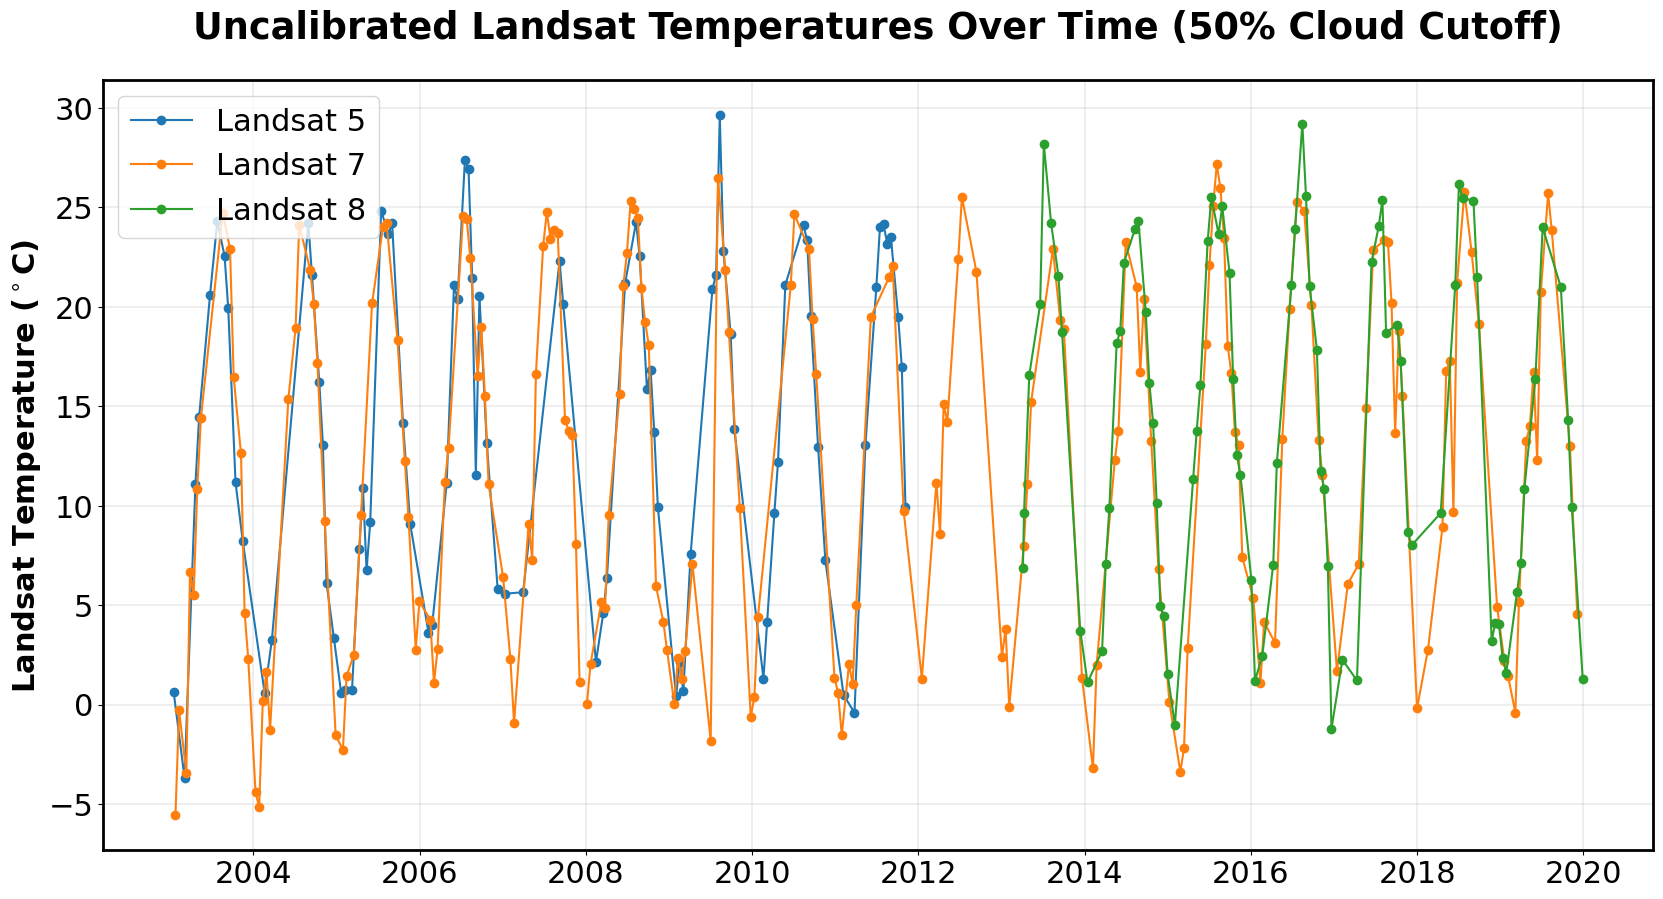

In [55]:
#@title Landsat Temperature Over Time Plot

### Plots Landsat 5,7, and 8 temperatures over time ###

# Updates plotting parameters #
plt.rcParams.update({'font.size': 22})
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["axes.titleweight"] = "bold"
plt.rcParams['axes.linewidth'] = 2

# Creates arrays that will be filled with datetime objects for plotting #
L5datesTick = np.empty(len(L5dates_filtered), dtype=dt)
L7datesTick = np.empty(len(L7dates_filtered), dtype=dt)
L8datesTick = np.empty(len(L8dates_filtered), dtype=dt)

# Fills arrays created above with datetime objects #
for i in range(len(L5dates_filtered)):
  L5datesTick[i] = dt.strptime(L5dates_filtered[i][0:10] + " " + L5dates[i][11:19], '%Y-%m-%d %H:%M:%S')
for i in range(len(L7dates_filtered)):
  L7datesTick[i] = dt.strptime(L7dates_filtered[i][0:10] + " " + L7dates[i][11:19], '%Y-%m-%d %H:%M:%S')
for i in range(len(L8dates_filtered)):
  L8datesTick[i] = dt.strptime(L8dates_filtered[i][0:10] + " " + L8dates[i][11:19], '%Y-%m-%d %H:%M:%S')

# Plots Landsat temperatures over time #
fig, ax = plt.subplots(figsize = [20, 10])
ax.plot(L5datesTick, np.nanmean(L5temps_landsat_filtered, 0), marker = 'o')
ax.plot(L7datesTick, np.nanmean(L7temps_landsat_filtered, 0), marker = 'o')
ax.plot(L8datesTick, np.nanmean(L8temps_landsat_filtered, 0), marker = 'o')
legend = ax.legend(["Landsat 5", "Landsat 7", "Landsat 8"], loc = "upper left")
plt.title("Uncalibrated Landsat Temperatures Over Time (" + str(cloud_cutoff) + "% Cloud Cutoff)", pad=30)
plt.ylabel("Landsat Temperature ($^\circ$C)")
plt.grid(lw=0.3)
plt.show()

/var/folders/0y/r_pk_m1j77vbq82t895ph8780000gq/T/ipykernel_14753/27728024.py:26: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  legend1.legendHandles[0].set_color('black')
/var/folders/0y/r_pk_m1j77vbq82t895ph8780000gq/T/ipykernel_14753/27728024.py:27: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  legend1.legendHandles[1].set_color('black')
/var/folders/0y/r_pk_m1j77vbq82t895ph8780000gq/T/ipykernel_14753/27728024.py:28: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  legend1.legendHandles[2].set_color('black')
/var/folders/0y/r_pk_m1j77vbq82t895ph8780000gq/T/ipykernel_14753/27728024.py:30: MatplotlibDeprecationWarning: The legendHan

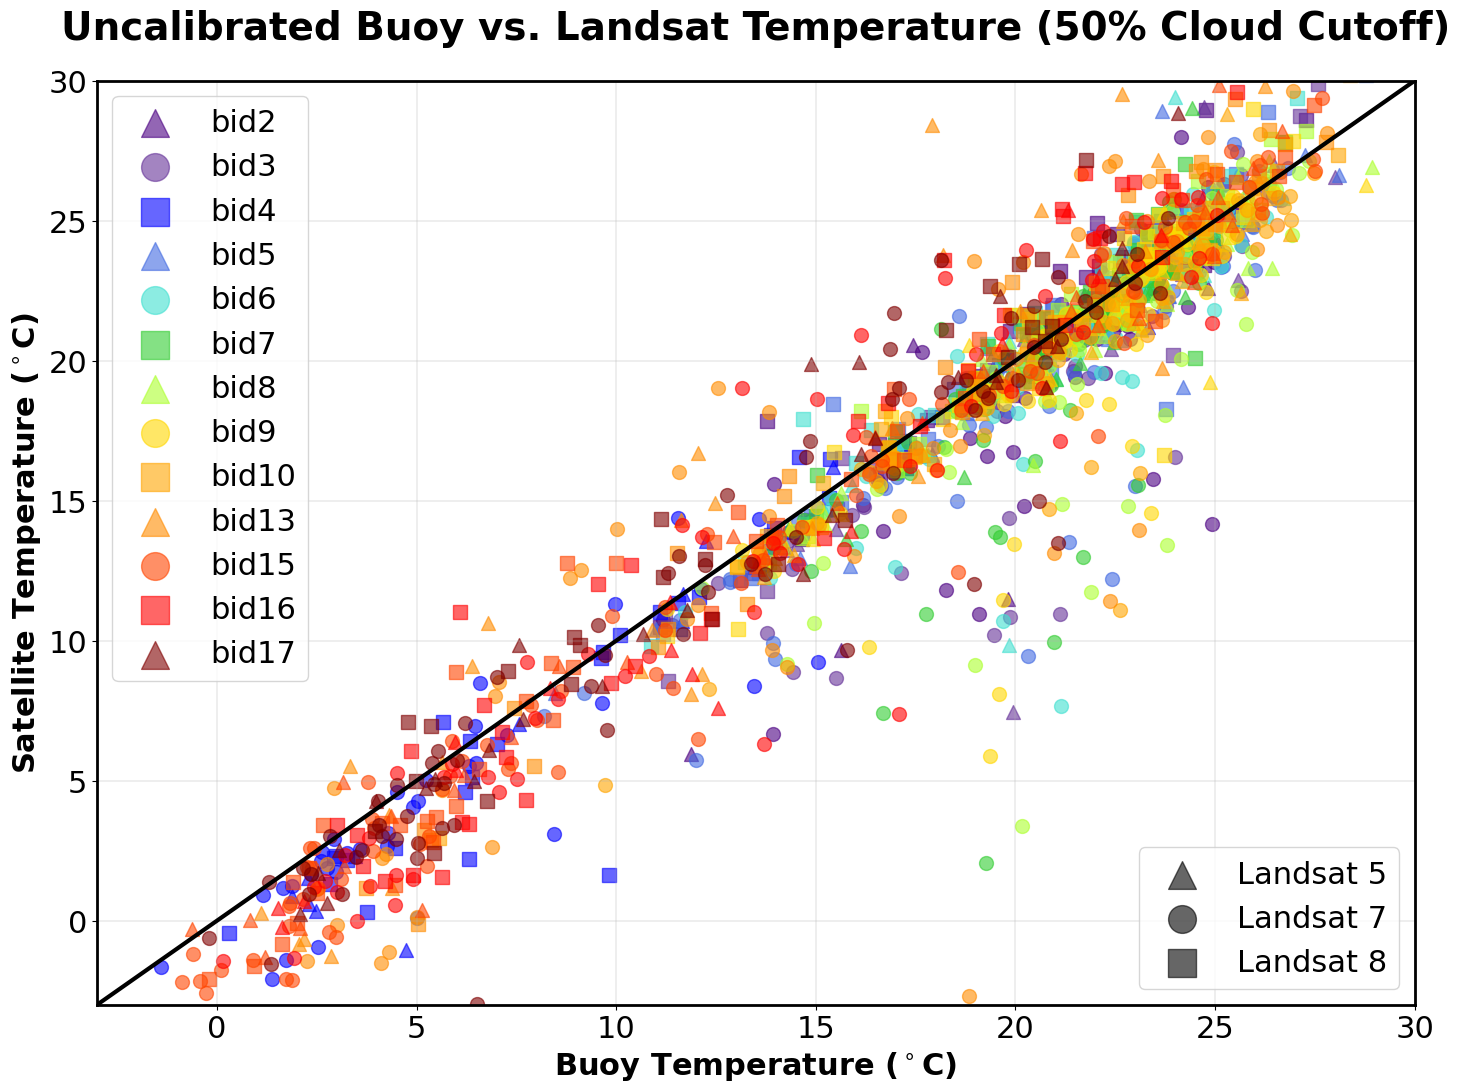

In [56]:
#@title Buoy vs. Landsat Plot

### Plots buoy temperatures vs. Landsat temperatures ###

# Updates plotting parameters #
plt.rcParams.update({'font.size': 22})
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["axes.titleweight"] = "bold"
plt.rcParams['axes.linewidth'] = 2

# Plots buoy temperatures vs. Landsat temperatures #
colors = ["indigo", "rebeccapurple", "blue", "royalblue", "turquoise", "limegreen", "greenyellow", "gold", "orange", "darkorange", "orangered", "red", "maroon"]
fig, ax = plt.subplots(figsize=(17, 12))
for i in range(len(fnames)):
  ax.scatter(L5temps_buoy_filtered[i], L5temps_landsat_filtered[i], marker='^', s=100, c = colors[i], alpha=0.6)
  ax.scatter(L7temps_buoy_filtered[i], L7temps_landsat_filtered[i], marker='o', s=100, c = colors[i], alpha=0.6)
  ax.scatter(L8temps_buoy_filtered[i], L8temps_landsat_filtered[i], marker='s', s=100, c = colors[i], alpha=0.6)
plt.xlim([-3, 30])
plt.ylim([-3, 30])
plt.title("Uncalibrated Buoy vs. Landsat Temperature (" + str(cloud_cutoff) + "% Cloud Cutoff)", pad = 30, fontdict={'fontsize': 28})
plt.xlabel("Buoy Temperature ($^\circ$C)")
plt.ylabel("Satellite Temperature ($^\circ$C)")
legend1 = ax.legend(["Landsat 5", "Landsat 7", "Landsat 8"], loc="lower right", markerscale=2)
legend2 = ax.legend(fnames, loc="upper left", markerscale=2)
ax.add_artist(legend1)
legend1.legendHandles[0].set_color('black')
legend1.legendHandles[1].set_color('black')
legend1.legendHandles[2].set_color('black')
for i in range(len(fnames)):
  legend2.legendHandles[i].set_color(colors[i])
plt.plot([-5,35],[-5,35], c='black', lw=3)
plt.grid(lw=0.3)
plt.show()

/var/folders/0y/r_pk_m1j77vbq82t895ph8780000gq/T/ipykernel_14753/3086348650.py:50: RuntimeWarning: Mean of empty slice
  BuoyMonthAvgL5[months.index(month)].append(np.nanmean(L5temps_buoy_filtered[:,i]))
/var/folders/0y/r_pk_m1j77vbq82t895ph8780000gq/T/ipykernel_14753/3086348650.py:54: RuntimeWarning: Mean of empty slice
  BuoyMonthAvgL7[months.index(month)].append(np.nanmean(L7temps_buoy_filtered[:,i]))
/var/folders/0y/r_pk_m1j77vbq82t895ph8780000gq/T/ipykernel_14753/3086348650.py:53: RuntimeWarning: Mean of empty slice
  L7monthAvg[months.index(month)].append(np.nanmean(L7temps_landsat_filtered[:,i]))
/var/folders/0y/r_pk_m1j77vbq82t895ph8780000gq/T/ipykernel_14753/3086348650.py:100: RuntimeWarning: Mean of empty slice
  ax.scatter(L7datesTick, np.nanmean(L7temps_landsat_filtered, 0), marker = 'o', c="royalblue", alpha=0.6, s=100)
/var/folders/0y/r_pk_m1j77vbq82t895ph8780000gq/T/ipykernel_14753/3086348650.py:102: RuntimeWarning: Mean of empty slice
  ax.scatter(L5datesTick, np.nanmea

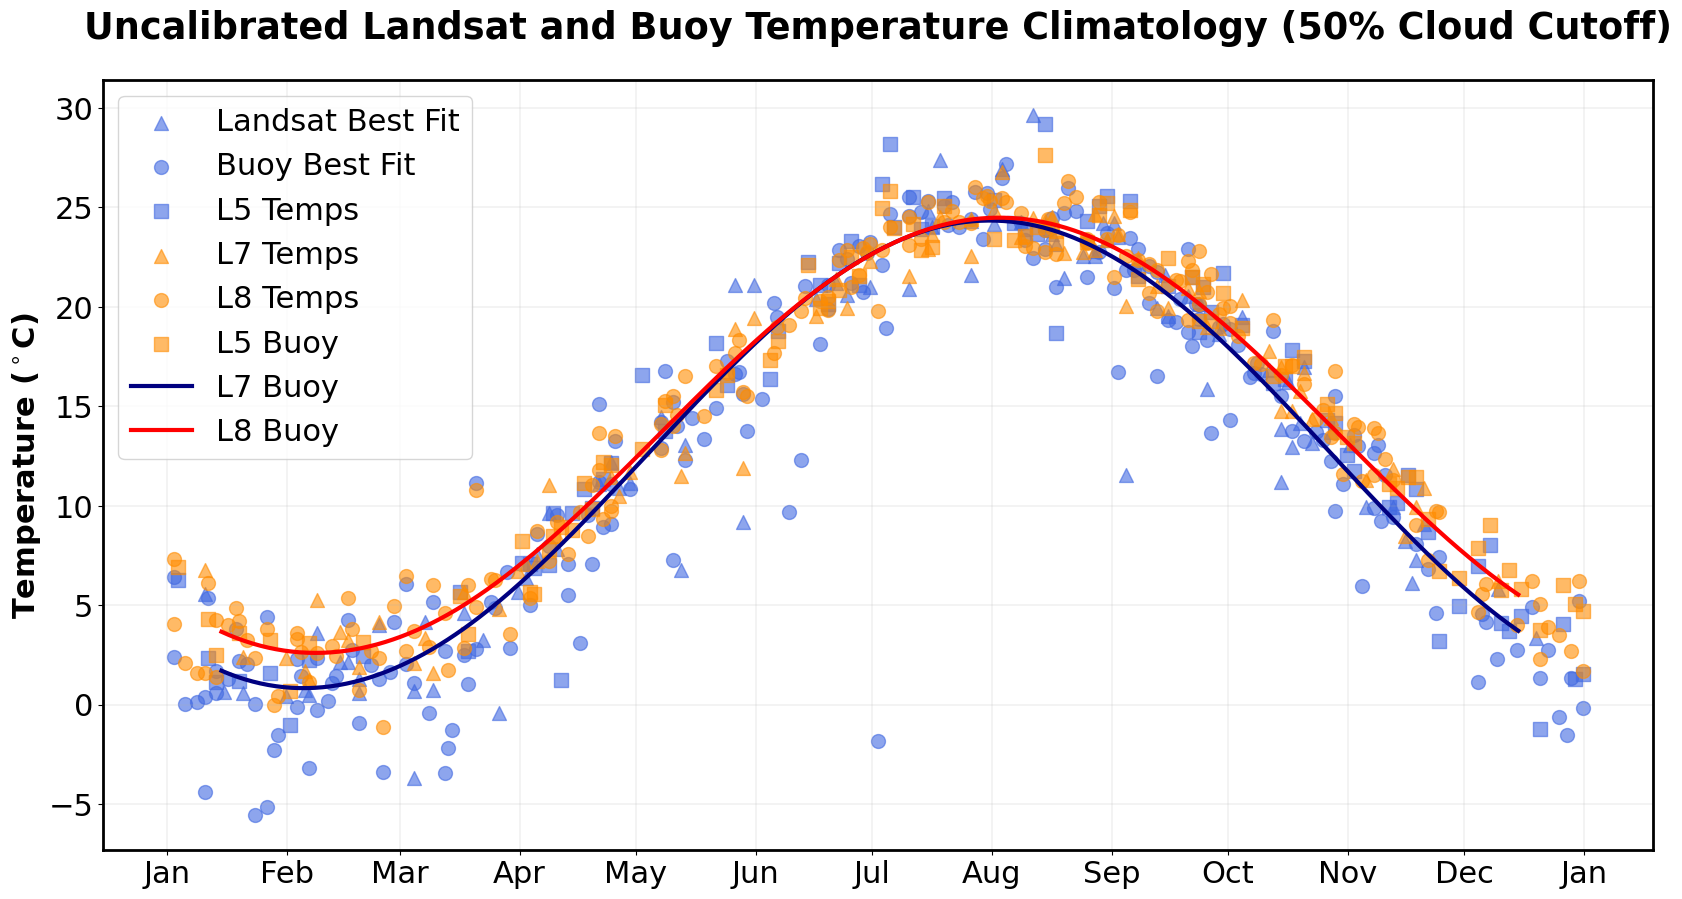

In [57]:
#@title Climatology Plot

### Plots a climatology of Landsat and buoy temperature data, with lines
### of best fit ###

# Updates plotting parameters #
plt.rcParams.update({'font.size': 22})
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["axes.titleweight"] = "bold"
plt.rcParams['axes.linewidth'] = 2

# Creates arrays that will be filled with datetime objects for plotting #
L5datesTick = np.empty(len(L5dates_filtered), dtype=dt)
L7datesTick = np.empty(len(L7dates_filtered), dtype=dt)
L8datesTick = np.empty(len(L8dates_filtered), dtype=dt)

# Fills arrays created above with datetime objects #
for i in range(len(L5dates_filtered)):
  L5datesTick[i] = dt.strptime("2000" + L5dates_filtered[i][4:10] + " " + L5dates_filtered[i][11:19], '%Y-%m-%d %H:%M:%S')
for i in range(len(L7dates_filtered)):
  L7datesTick[i] = dt.strptime("2000" + L7dates_filtered[i][4:10] + " " + L7dates_filtered[i][11:19], '%Y-%m-%d %H:%M:%S')
for i in range(len(L8dates_filtered)):
  L8datesTick[i] = dt.strptime("2000" + L8dates_filtered[i][4:10] + " " + L8dates_filtered[i][11:19], '%Y-%m-%d %H:%M:%S')

# Arrays used to find the monthly means for Landsat and buoy temperatures #
months = ["01","02","03","04","05","06","07","08","09","10","11","12"]
dates = [dt(2000,1,15),dt(2000,2,15),dt(2000,3,15),dt(2000,4,15),
         dt(2000,5,15),dt(2000,6,15),dt(2000,7,15),dt(2000,8,15),
         dt(2000,9,15),dt(2000,10,15),dt(2000,11,15),dt(2000,12,15)]
stamps = np.array([dt(2000,1,15).timestamp(), dt(2000,2,15).timestamp(),
                   dt(2000,3,15).timestamp(), dt(2000,4,15).timestamp(),
                   dt(2000,5,15).timestamp(), dt(2000,6,15).timestamp(),
                   dt(2000,7,15).timestamp(), dt(2000,8,15).timestamp(),
                   dt(2000,9,15).timestamp(), dt(2000,10,15).timestamp(),
                   dt(2000,11,15).timestamp(), dt(2000,12,15).timestamp()])

# Creates 12 empty lists (one list per month), that will be filled below #
L5monthAvg = [[] for Null in range(12)]
L7monthAvg = [[] for Null in range(12)]
L8monthAvg = [[] for Null in range(12)]
BuoyMonthAvgL5 = [[] for Null in range(12)]
BuoyMonthAvgL7 = [[] for Null in range(12)]
BuoyMonthAvgL8 = [[] for Null in range(12)]

# Loops through each filtered dates array and fills the above arrays with
# temperature values based on month #
for i in range(len(L5dates_filtered)):
  month = str(L5dates_filtered[i])[5:7]
  L5monthAvg[months.index(month)].append(np.nanmean(L5temps_landsat_filtered[:,i]))
  BuoyMonthAvgL5[months.index(month)].append(np.nanmean(L5temps_buoy_filtered[:,i]))
for i in range(len(L7dates_filtered)):
  month = str(L7dates_filtered[i])[5:7]
  L7monthAvg[months.index(month)].append(np.nanmean(L7temps_landsat_filtered[:,i]))
  BuoyMonthAvgL7[months.index(month)].append(np.nanmean(L7temps_buoy_filtered[:,i]))
for i in range(len(L8dates_filtered)):
  month = str(L8dates_filtered[i])[5:7]
  L8monthAvg[months.index(month)].append(np.nanmean(L8temps_landsat_filtered[:,i]))
  BuoyMonthAvgL8[months.index(month)].append(np.nanmean(L8temps_buoy_filtered[:,i]))

# Calculates the mean temperature for each month #
L578monthAvg = np.empty(12)*np.nan
BuoyMonthAvgL578 = np.empty(12)*np.nan
for i in range(len(months)):
  L5monthAvg[i] = np.nanmean(np.array(L5monthAvg[i]))
  L7monthAvg[i] = np.nanmean(np.array(L7monthAvg[i]))
  L8monthAvg[i] = np.nanmean(np.array(L8monthAvg[i]))
  L578monthAvg[i] = np.nanmean(np.array([L5monthAvg[i], L7monthAvg[i], L8monthAvg[i]]))
  BuoyMonthAvgL5[i] = np.nanmean(np.array(BuoyMonthAvgL5[i]))
  BuoyMonthAvgL7[i] = np.nanmean(np.array(BuoyMonthAvgL7[i]))
  BuoyMonthAvgL8[i] = np.nanmean(np.array(BuoyMonthAvgL8[i]))
  BuoyMonthAvgL578[i] = np.nanmean(np.array([BuoyMonthAvgL5[i], BuoyMonthAvgL7[i], BuoyMonthAvgL8[i]]))

# Line of best fit, sets initial parameters and creates function #
def test_func(t, T0, delta_T, tau, phi):
    return T0 + (delta_T / 2) * np.sin(2 * np.pi * t / tau + phi)
T0 = 20
delta_T = 35
tau = 365*24*3600
phi = 2*np.pi*4*30.5*3600/tau
landsat_params, landsat_params_covariance = optimize.curve_fit(test_func, stamps, L578monthAvg, p0=[T0, delta_T, tau, phi])
buoy_params, buoy_params_covariance = optimize.curve_fit(test_func, stamps, BuoyMonthAvgL578, p0=[T0, delta_T, tau, phi])

# Vectorizes a function that converts timestamp to datetime #
def convertTime(timestamp):
  return(dt.fromtimestamp(timestamp))
convertTimeVectorized = np.vectorize(convertTime)

# Interpolates the line of best fit to make smooth curve #
landsat_spline = make_interp_spline(stamps, test_func(stamps, landsat_params[0], landsat_params[1], landsat_params[2], landsat_params[3]))
buoy_spline = make_interp_spline(stamps, test_func(stamps, buoy_params[0], buoy_params[1], buoy_params[2], buoy_params[3]))
stamps_spline = np.linspace(stamps.min(), stamps.max(), 500)
dates_spline = convertTimeVectorized(stamps_spline)
landsat_temps_spline = landsat_spline(stamps_spline)
buoy_temps_spline = buoy_spline(stamps_spline)

# Plots the Landsat and buoy temperatures over one year (averaged by buoy), as
# well as two lines of best fit for the Landsat and buoy temperatures #
fig, ax = plt.subplots(figsize = [20, 10])
ax.scatter(L5datesTick, np.nanmean(L5temps_landsat_filtered, 0), marker = '^', c="royalblue", alpha=0.6, s=100)
ax.scatter(L7datesTick, np.nanmean(L7temps_landsat_filtered, 0), marker = 'o', c="royalblue", alpha=0.6, s=100)
ax.scatter(L8datesTick, np.nanmean(L8temps_landsat_filtered, 0), marker = 's', c="royalblue", alpha=0.6, s=100)
ax.scatter(L5datesTick, np.nanmean(L5temps_buoy_filtered, 0), marker = '^', c="darkorange", alpha=0.6, s=100)
ax.scatter(L7datesTick, np.nanmean(L7temps_buoy_filtered, 0), marker = 'o', c="darkorange", alpha=0.6, s=100)
ax.scatter(L8datesTick, np.nanmean(L8temps_buoy_filtered, 0), marker = 's', c="darkorange", alpha=0.6, s=100)
ax.plot(dates_spline, landsat_temps_spline, c="navy", lw=3)
ax.plot(dates_spline, buoy_temps_spline, c="red", lw=3)
legend = ax.legend(["Landsat Best Fit", "Buoy Best Fit", "L5 Temps", "L7 Temps", "L8 Temps", "L5 Buoy", "L7 Buoy", "L8 Buoy"], loc = "upper left")
plt.title("Uncalibrated Landsat and Buoy Temperature Climatology (" + str(cloud_cutoff) + "% Cloud Cutoff)", pad=30)
plt.ylabel("Temperature ($^\circ$C)")
date_form = DateFormatter("%b")
ax.xaxis.set_major_formatter(date_form)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
ax.grid(lw=0.2)
plt.show()

In [58]:
### Table with number of datapoints, bias, and standard deviation of each
### satellite ###

Table = PrettyTable(["Satellite", "Datapoints", "Bias", "STD"])
Table.add_row(["Landsat 5", str(np.count_nonzero(~np.isnan(L5temps_buoy_filtered + L5temps_landsat_filtered))), 
                 str(round(np.nanmean(np.array(L5temps_landsat_filtered)-np.array(L5temps_buoy_filtered)),3)),
                 str(round(np.nanstd(np.array(L5temps_landsat_filtered)-np.array(L5temps_buoy_filtered)),2))])
Table.add_row(["Landsat 7", str(np.count_nonzero(~np.isnan(L7temps_buoy_filtered + L7temps_landsat_filtered))), 
                 str(round(np.nanmean(np.array(L7temps_landsat_filtered)-np.array(L7temps_buoy_filtered)),3)),
                 str(round(np.nanstd(np.array(L7temps_landsat_filtered)-np.array(L7temps_buoy_filtered)),2))])
Table.add_row(["Landsat 8", str(np.count_nonzero(~np.isnan(L8temps_buoy_filtered + L8temps_landsat_filtered))), 
                 str(round(np.nanmean(np.array(L8temps_landsat_filtered)-np.array(L8temps_buoy_filtered)),3)),
                 str(round(np.nanstd(np.array(L8temps_landsat_filtered)-np.array(L8temps_buoy_filtered)),2))])
print(Table)

+-----------+------------+--------+------+
| Satellite | Datapoints |  Bias  | STD  |
+-----------+------------+--------+------+
| Landsat 5 |    367     | -0.45  | 2.11 |
| Landsat 7 |    923     | -1.094 | 2.78 |
| Landsat 8 |    466     | 0.178  | 1.62 |
+-----------+------------+--------+------+


# Bias Calibration

In [60]:
### Retrieves dates, cloud cover, Landsat temperature, and buoy temperature
### arrays from csv files in drive ###

def readCSV(fname):
  file = open(fpath + fname + ".csv")
  csvreader = csv.reader(file)
  array = []
  for row in csvreader:
    array.append(row)
  return np.array(array)

fpath = './dates_clouds/'
L5dates = np.squeeze(readCSV("L5dates"), 1)
L7dates = np.squeeze(readCSV("L7dates"), 1)
L8dates = np.squeeze(readCSV("L8dates"), 1)
L5clouds = np.squeeze(readCSV("L5clouds"), 1).astype(float)
L7clouds = np.squeeze(readCSV("L7clouds"), 1).astype(float)
L8clouds = np.squeeze(readCSV("L8clouds"), 1).astype(float)
fpath = './landsat_data/'
L5temps_landsat = readCSV("L5temps").astype(float)
L7temps_landsat = readCSV("L7temps").astype(float)
L8temps_landsat = readCSV("L8temps").astype(float)
fpath = './buoy_temp_data/'
L5temps_buoy = readCSV("L5BuoyData").astype(float)
L7temps_buoy = readCSV("L7BuoyData").astype(float)
L8temps_buoy = readCSV("L8BuoyData").astype(float)

In [61]:
### Filters date, Landsat, and buoy arrays by cloud cutoff, creates
### calibrated Landsat dataset by correcting for bias ###

cloud_cutoff = 50
L5dates_filtered = L5dates[np.nonzero(L5clouds < cloud_cutoff)]
L7dates_filtered = L7dates[np.nonzero(L7clouds < cloud_cutoff)]
L8dates_filtered = L8dates[np.nonzero(L8clouds < cloud_cutoff)]
L5temps_landsat_filtered = np.squeeze(L5temps_landsat[:, np.nonzero(L5clouds < cloud_cutoff)], 1)
L7temps_landsat_filtered = np.squeeze(L7temps_landsat[:, np.nonzero(L7clouds < cloud_cutoff)], 1)
L8temps_landsat_filtered = np.squeeze(L8temps_landsat[:, np.nonzero(L8clouds < cloud_cutoff)], 1)
L5temps_buoy_filtered = np.squeeze(L5temps_buoy[:, np.nonzero(L5clouds < cloud_cutoff)], 1)
L7temps_buoy_filtered = np.squeeze(L7temps_buoy[:, np.nonzero(L7clouds < cloud_cutoff)], 1)
L8temps_buoy_filtered = np.squeeze(L8temps_buoy[:, np.nonzero(L8clouds < cloud_cutoff)], 1)
L5bias = np.nanmean(L5temps_landsat_filtered-L5temps_buoy_filtered)
L7bias = np.nanmean(L7temps_landsat_filtered-L7temps_buoy_filtered)
L8bias = np.nanmean(L8temps_landsat_filtered-L8temps_buoy_filtered)
L5temps_landsat_calibrated = L5temps_landsat_filtered - L5bias
L7temps_landsat_calibrated = L7temps_landsat_filtered - L7bias
L8temps_landsat_calibrated = L8temps_landsat_filtered - L8bias

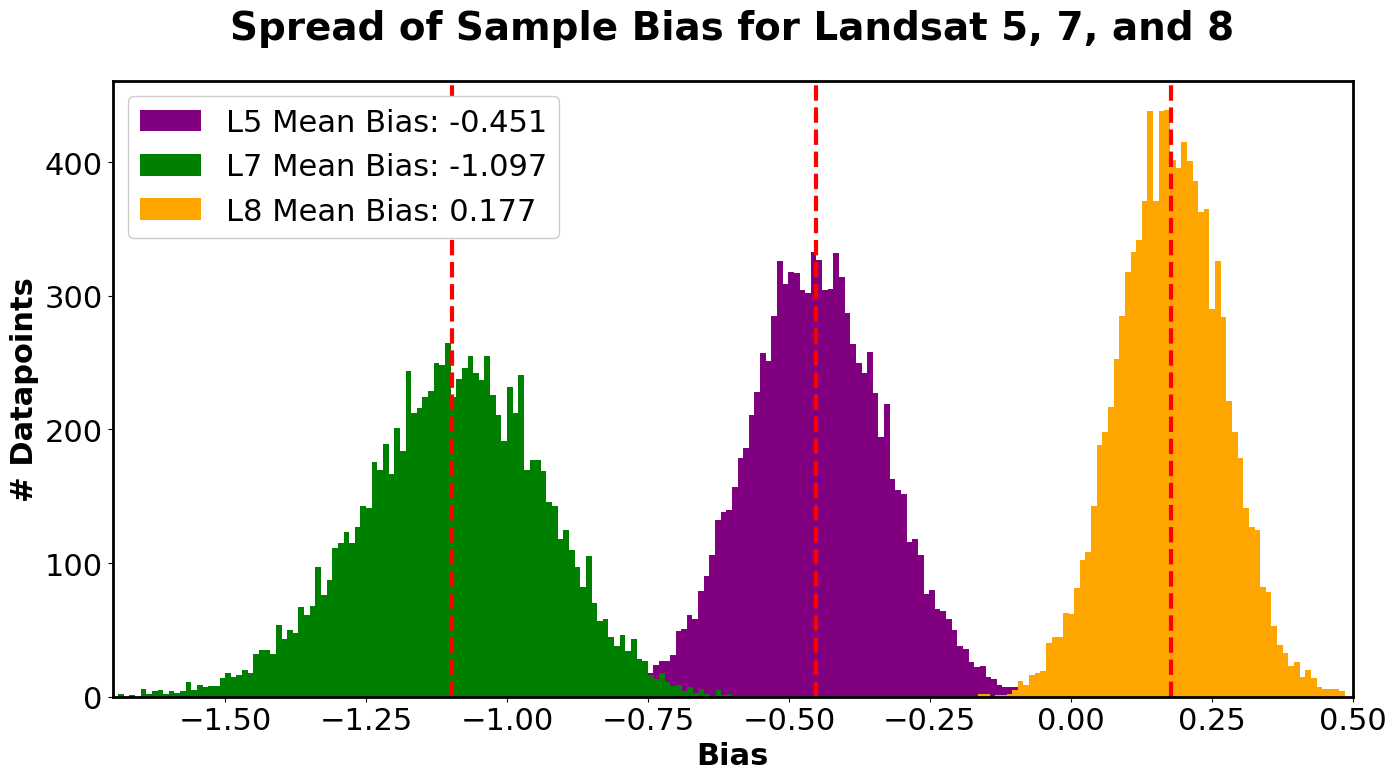

In [62]:
#@title Spread of Sample Bias Plot

### Plots the bias of Landsat 5, 7, and 8 using random samples of the bias ###

# Updates plotting parameters #
plt.rcParams.update({'font.size': 22})
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["axes.titleweight"] = "bold"
plt.rcParams['axes.linewidth'] = 2

# Calculates bias between buoy and landsat data, removes nan values #
L5bias = L5temps_landsat_filtered - L5temps_buoy_filtered
L7bias = L7temps_landsat_filtered - L7temps_buoy_filtered
L8bias = L8temps_landsat_filtered - L8temps_buoy_filtered
L5bias = L5bias[np.where(np.isnan(L5bias)==0)]
L7bias = L7bias[np.where(np.isnan(L7bias)==0)]
L8bias = L8bias[np.where(np.isnan(L8bias)==0)]

# Creates 10000 sample biases, taking the mean of 300 random points each time #
sample_size = 300
L5sample_mean = []
L7sample_mean = []
L8sample_mean = []
for i in range(10000):
    L5sample = np.random.choice(L5bias, size=sample_size)
    L5sample_mean.append(L5sample.mean())
    L7sample = np.random.choice(L7bias, size=sample_size)
    L7sample_mean.append(L7sample.mean())
    L8sample = np.random.choice(L8bias, size=sample_size)
    L8sample_mean.append(L8sample.mean())

# Plots the sample biases for the three Landsat sattelites #
plt.figure(figsize=(16,8))
plt.hist(L5sample_mean, bins=np.arange(np.min(L5sample_mean), np.max(L5sample_mean), .01), color = "purple")
plt.hist(L7sample_mean, bins=np.arange(np.min(L7sample_mean), np.max(L7sample_mean), .01), color = "green")
plt.hist(L8sample_mean, bins=np.arange(np.min(L8sample_mean), np.max(L8sample_mean), .01), color = "orange")
plt.xlabel("Bias")
plt.ylabel("# Datapoints")
plt.title("Spread of Sample Bias for Landsat 5, 7, and 8", pad = 30, fontdict={'fontsize': 28})
plt.legend(["L5 Mean Bias: " + str(round(np.nanmean(L5sample_mean),3)),
            "L7 Mean Bias: " + str(round(np.nanmean(L7sample_mean),3)),
            "L8 Mean Bias: " + str(round(np.nanmean(L8sample_mean),3))], loc="upper left", framealpha=1)
plt.axvline(np.nanmean(L5sample_mean), color='red', linestyle='dashed', linewidth=3)
plt.axvline(np.nanmean(L7sample_mean), color='red', linestyle='dashed', linewidth=3)
plt.axvline(np.nanmean(L8sample_mean), color='red', linestyle='dashed', linewidth=3)
plt.xlim([-1.70,0.5])
plt.show()

/var/folders/0y/r_pk_m1j77vbq82t895ph8780000gq/T/ipykernel_14753/2587388101.py:27: RuntimeWarning: Mean of empty slice
  ax.plot(L7datesTick, np.nanmean(L7temps_landsat_calibrated, 0), marker = 'o')


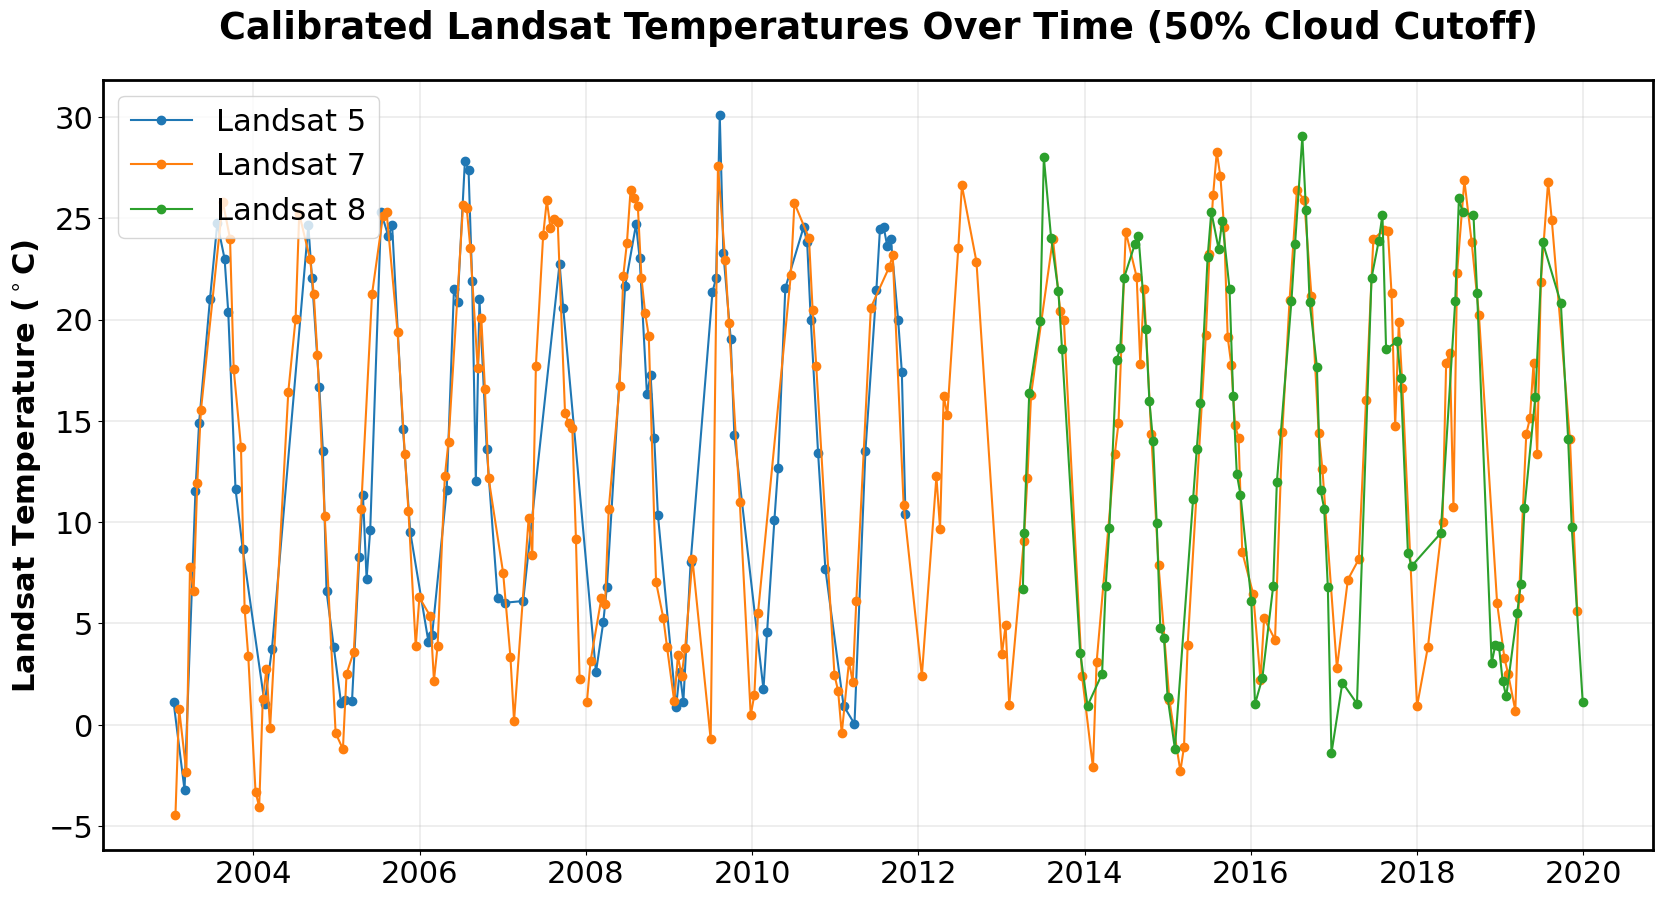

In [63]:
#@title Landsat Temperature Over Time Plot (Bias Calibrated)

### Plots Landsat 5,7, and 8 temperatures over time ###

# Updates plotting parameters #
plt.rcParams.update({'font.size': 22})
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["axes.titleweight"] = "bold"
plt.rcParams['axes.linewidth'] = 2

# Creates arrays that will be filled with datetime objects for plotting #
L5datesTick = np.empty(len(L5dates_filtered), dtype=dt)
L7datesTick = np.empty(len(L7dates_filtered), dtype=dt)
L8datesTick = np.empty(len(L8dates_filtered), dtype=dt)

# Fills arrays created above with datetime objects #
for i in range(len(L5dates_filtered)):
  L5datesTick[i] = dt.strptime(L5dates_filtered[i][0:10] + " " + L5dates[i][11:19], '%Y-%m-%d %H:%M:%S')
for i in range(len(L7dates_filtered)):
  L7datesTick[i] = dt.strptime(L7dates_filtered[i][0:10] + " " + L7dates[i][11:19], '%Y-%m-%d %H:%M:%S')
for i in range(len(L8dates_filtered)):
  L8datesTick[i] = dt.strptime(L8dates_filtered[i][0:10] + " " + L8dates[i][11:19], '%Y-%m-%d %H:%M:%S')

# Plots Landsat temperatures over time #
fig, ax = plt.subplots(figsize = [20, 10])
ax.plot(L5datesTick, np.nanmean(L5temps_landsat_calibrated, 0), marker = 'o')
ax.plot(L7datesTick, np.nanmean(L7temps_landsat_calibrated, 0), marker = 'o')
ax.plot(L8datesTick, np.nanmean(L8temps_landsat_calibrated, 0), marker = 'o')
legend = ax.legend(["Landsat 5", "Landsat 7", "Landsat 8"], loc = "upper left")
plt.title("Calibrated Landsat Temperatures Over Time (" + str(cloud_cutoff) + "% Cloud Cutoff)", pad=30)
plt.ylabel("Landsat Temperature ($^\circ$C)")
plt.grid(lw=0.3)
plt.show()

/var/folders/0y/r_pk_m1j77vbq82t895ph8780000gq/T/ipykernel_14753/2103819772.py:26: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  legend1.legendHandles[0].set_color('black')
/var/folders/0y/r_pk_m1j77vbq82t895ph8780000gq/T/ipykernel_14753/2103819772.py:27: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  legend1.legendHandles[1].set_color('black')
/var/folders/0y/r_pk_m1j77vbq82t895ph8780000gq/T/ipykernel_14753/2103819772.py:28: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  legend1.legendHandles[2].set_color('black')
/var/folders/0y/r_pk_m1j77vbq82t895ph8780000gq/T/ipykernel_14753/2103819772.py:30: MatplotlibDeprecationWarning: The l

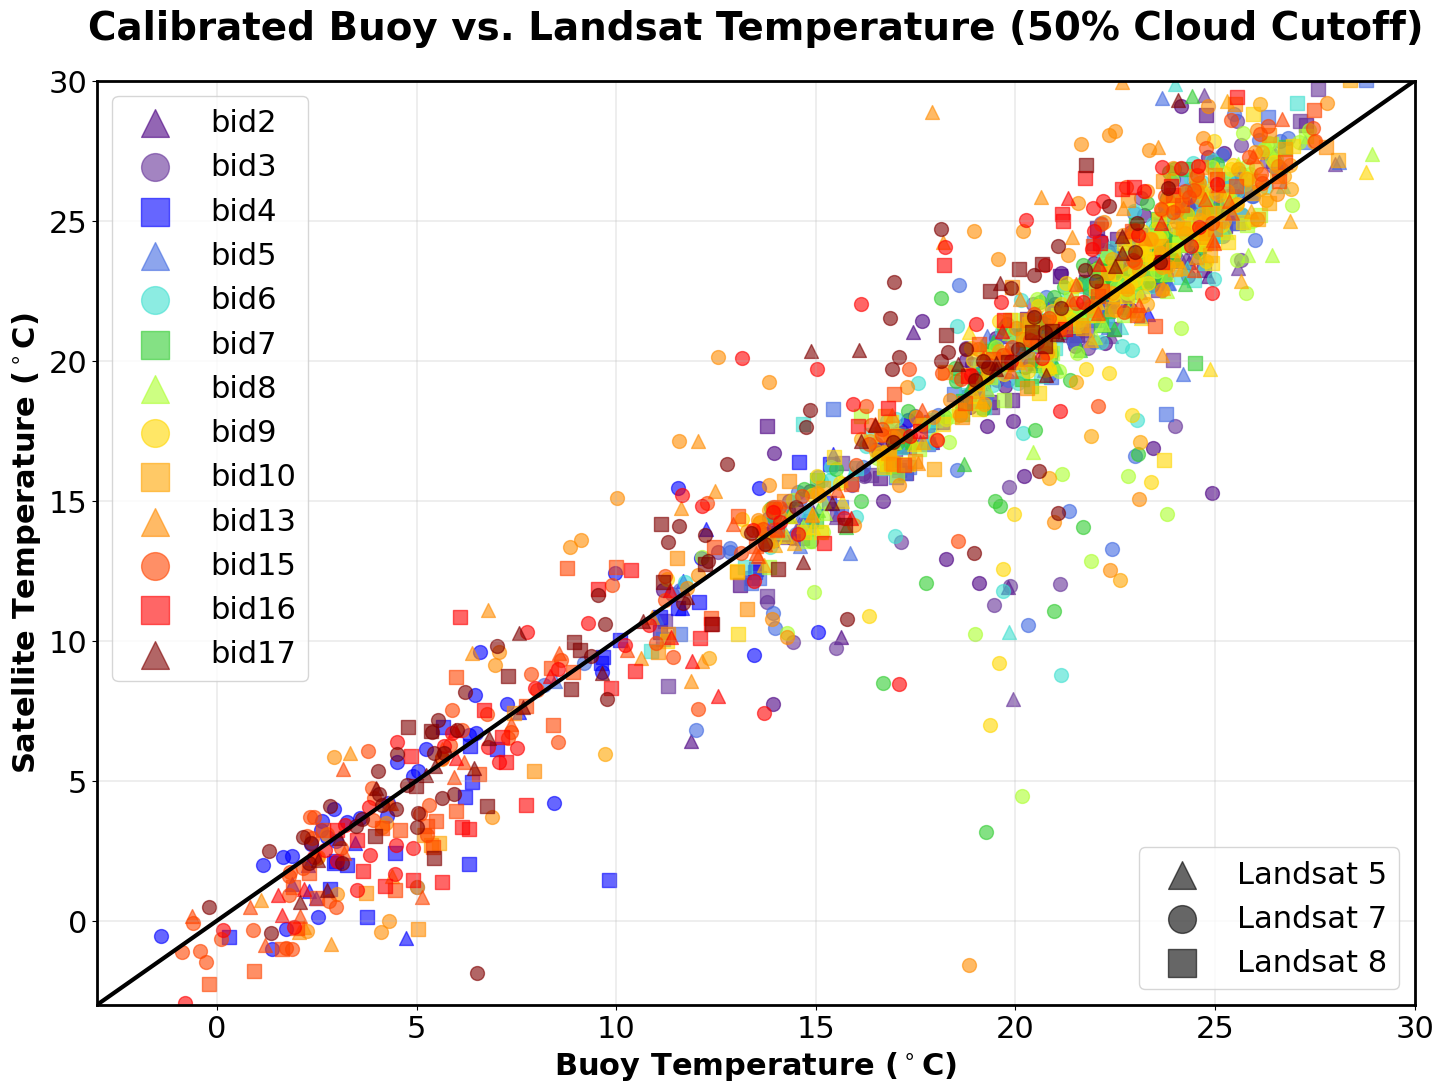

In [64]:
#@title Buoy vs. Landsat Plot (Bias Calibrated)

### Plots buoy temperatures vs. Landsat temperatures ###

# Updates plotting parameters #
plt.rcParams.update({'font.size': 22})
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["axes.titleweight"] = "bold"
plt.rcParams['axes.linewidth'] = 2

# Plots buoy temperatures vs. Landsat temperatures #
colors = ["indigo", "rebeccapurple", "blue", "royalblue", "turquoise", "limegreen", "greenyellow", "gold", "orange", "darkorange", "orangered", "red", "maroon"]
fig, ax = plt.subplots(figsize=(17, 12))
for i in range(len(fnames)):
  ax.scatter(L5temps_buoy_filtered[i], L5temps_landsat_calibrated[i], marker='^', s=100, c = colors[i], alpha=0.6)
  ax.scatter(L7temps_buoy_filtered[i], L7temps_landsat_calibrated[i], marker='o', s=100, c = colors[i], alpha=0.6)
  ax.scatter(L8temps_buoy_filtered[i], L8temps_landsat_calibrated[i], marker='s', s=100, c = colors[i], alpha=0.6)
plt.xlim([-3, 30])
plt.ylim([-3, 30])
plt.title("Calibrated Buoy vs. Landsat Temperature (" + str(cloud_cutoff) + "% Cloud Cutoff)", pad = 30, fontdict={'fontsize': 28})
plt.xlabel("Buoy Temperature ($^\circ$C)")
plt.ylabel("Satellite Temperature ($^\circ$C)")
legend1 = ax.legend(["Landsat 5", "Landsat 7", "Landsat 8"], loc="lower right", markerscale=2)
legend2 = ax.legend(fnames, loc="upper left", markerscale=2)
ax.add_artist(legend1)
legend1.legendHandles[0].set_color('black')
legend1.legendHandles[1].set_color('black')
legend1.legendHandles[2].set_color('black')
for i in range(len(fnames)):
  legend2.legendHandles[i].set_color(colors[i])
plt.plot([-5,35],[-5,35], c='black', lw=3)
plt.grid(lw=0.3)
plt.show()

/var/folders/0y/r_pk_m1j77vbq82t895ph8780000gq/T/ipykernel_14753/2072295603.py:50: RuntimeWarning: Mean of empty slice
  BuoyMonthAvgL5[months.index(month)].append(np.nanmean(L5temps_buoy_filtered[:,i]))
/var/folders/0y/r_pk_m1j77vbq82t895ph8780000gq/T/ipykernel_14753/2072295603.py:54: RuntimeWarning: Mean of empty slice
  BuoyMonthAvgL7[months.index(month)].append(np.nanmean(L7temps_buoy_filtered[:,i]))
/var/folders/0y/r_pk_m1j77vbq82t895ph8780000gq/T/ipykernel_14753/2072295603.py:53: RuntimeWarning: Mean of empty slice
  L7monthAvg[months.index(month)].append(np.nanmean(L7temps_landsat_calibrated[:,i]))
/var/folders/0y/r_pk_m1j77vbq82t895ph8780000gq/T/ipykernel_14753/2072295603.py:100: RuntimeWarning: Mean of empty slice
  ax.scatter(L7datesTick, np.nanmean(L7temps_landsat_calibrated, 0), marker = 'o', c="royalblue", alpha=0.6, s=100)
/var/folders/0y/r_pk_m1j77vbq82t895ph8780000gq/T/ipykernel_14753/2072295603.py:102: RuntimeWarning: Mean of empty slice
  ax.scatter(L5datesTick, np.na

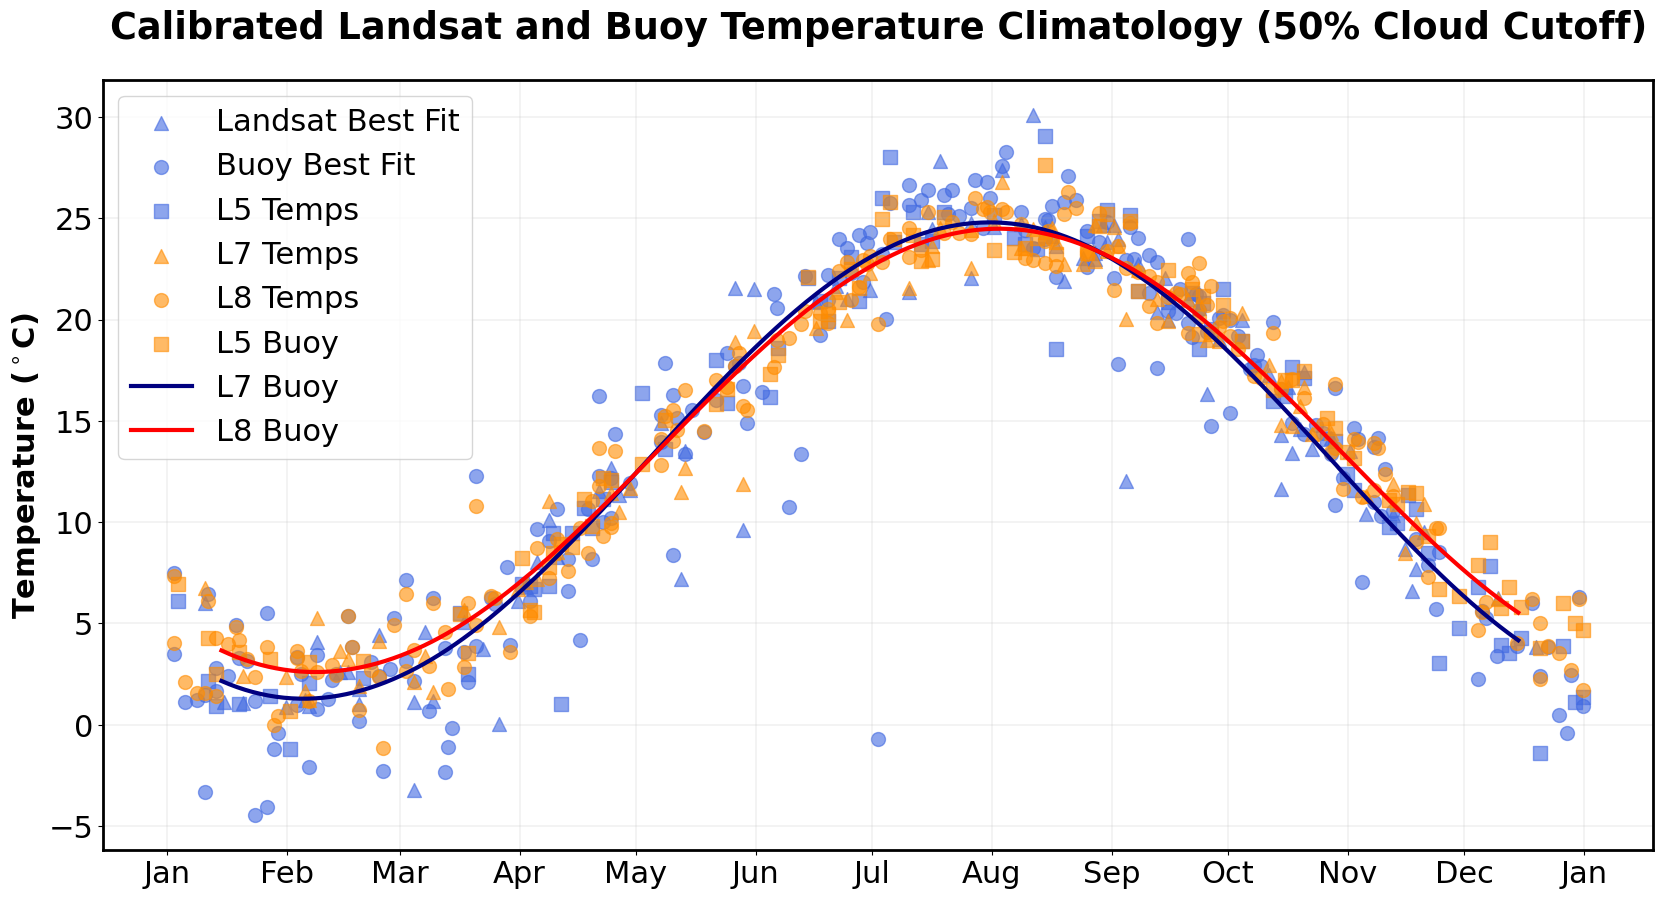

In [65]:
#@title Climatology Plot (Bias Calibrated)

### Plots a climatology of Landsat and buoy temperature data, with lines
### of best fit ###

# Updates plotting parameters #
plt.rcParams.update({'font.size': 22})
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["axes.titleweight"] = "bold"
plt.rcParams['axes.linewidth'] = 2

# Creates arrays that will be filled with datetime objects for plotting #
L5datesTick = np.empty(len(L5dates_filtered), dtype=dt)
L7datesTick = np.empty(len(L7dates_filtered), dtype=dt)
L8datesTick = np.empty(len(L8dates_filtered), dtype=dt)

# Fills arrays created above with datetime objects #
for i in range(len(L5dates_filtered)):
  L5datesTick[i] = dt.strptime("2000" + L5dates_filtered[i][4:10] + " " + L5dates_filtered[i][11:19], '%Y-%m-%d %H:%M:%S')
for i in range(len(L7dates_filtered)):
  L7datesTick[i] = dt.strptime("2000" + L7dates_filtered[i][4:10] + " " + L7dates_filtered[i][11:19], '%Y-%m-%d %H:%M:%S')
for i in range(len(L8dates_filtered)):
  L8datesTick[i] = dt.strptime("2000" + L8dates_filtered[i][4:10] + " " + L8dates_filtered[i][11:19], '%Y-%m-%d %H:%M:%S')

# Arrays used to find the monthly means for Landsat and buoy temperatures #
months = ["01","02","03","04","05","06","07","08","09","10","11","12"]
dates = [dt(2000,1,15),dt(2000,2,15),dt(2000,3,15),dt(2000,4,15),
         dt(2000,5,15),dt(2000,6,15),dt(2000,7,15),dt(2000,8,15),
         dt(2000,9,15),dt(2000,10,15),dt(2000,11,15),dt(2000,12,15)]
stamps = np.array([dt(2000,1,15).timestamp(), dt(2000,2,15).timestamp(),
                   dt(2000,3,15).timestamp(), dt(2000,4,15).timestamp(),
                   dt(2000,5,15).timestamp(), dt(2000,6,15).timestamp(),
                   dt(2000,7,15).timestamp(), dt(2000,8,15).timestamp(),
                   dt(2000,9,15).timestamp(), dt(2000,10,15).timestamp(),
                   dt(2000,11,15).timestamp(), dt(2000,12,15).timestamp()])

# Creates 12 empty lists (one list per month), that will be filled below #
L5monthAvg = [[] for Null in range(12)]
L7monthAvg = [[] for Null in range(12)]
L8monthAvg = [[] for Null in range(12)]
BuoyMonthAvgL5 = [[] for Null in range(12)]
BuoyMonthAvgL7 = [[] for Null in range(12)]
BuoyMonthAvgL8 = [[] for Null in range(12)]

# Loops through each filtered dates array and fills the above arrays with
# temperature values based on month #
for i in range(len(L5dates_filtered)):
  month = str(L5dates_filtered[i])[5:7]
  L5monthAvg[months.index(month)].append(np.nanmean(L5temps_landsat_calibrated[:,i]))
  BuoyMonthAvgL5[months.index(month)].append(np.nanmean(L5temps_buoy_filtered[:,i]))
for i in range(len(L7dates_filtered)):
  month = str(L7dates_filtered[i])[5:7]
  L7monthAvg[months.index(month)].append(np.nanmean(L7temps_landsat_calibrated[:,i]))
  BuoyMonthAvgL7[months.index(month)].append(np.nanmean(L7temps_buoy_filtered[:,i]))
for i in range(len(L8dates_filtered)):
  month = str(L8dates_filtered[i])[5:7]
  L8monthAvg[months.index(month)].append(np.nanmean(L8temps_landsat_calibrated[:,i]))
  BuoyMonthAvgL8[months.index(month)].append(np.nanmean(L8temps_buoy_filtered[:,i]))

# Calculates the mean temperature for each month #
L578monthAvg = np.empty(12)*np.nan
BuoyMonthAvgL578 = np.empty(12)*np.nan
for i in range(len(months)):
  L5monthAvg[i] = np.nanmean(np.array(L5monthAvg[i]))
  L7monthAvg[i] = np.nanmean(np.array(L7monthAvg[i]))
  L8monthAvg[i] = np.nanmean(np.array(L8monthAvg[i]))
  L578monthAvg[i] = np.nanmean(np.array([L5monthAvg[i], L7monthAvg[i], L8monthAvg[i]]))
  BuoyMonthAvgL5[i] = np.nanmean(np.array(BuoyMonthAvgL5[i]))
  BuoyMonthAvgL7[i] = np.nanmean(np.array(BuoyMonthAvgL7[i]))
  BuoyMonthAvgL8[i] = np.nanmean(np.array(BuoyMonthAvgL8[i]))
  BuoyMonthAvgL578[i] = np.nanmean(np.array([BuoyMonthAvgL5[i], BuoyMonthAvgL7[i], BuoyMonthAvgL8[i]]))

# Line of best fit, sets initial parameters and creates function #
def test_func(t, T0, delta_T, tau, phi):
    return T0 + (delta_T / 2) * np.sin(2 * np.pi * t / tau + phi)
T0 = 20
delta_T = 35
tau = 365*24*3600
phi = 2*np.pi*4*30.5*3600/tau
landsat_params, landsat_params_covariance = optimize.curve_fit(test_func, stamps, L578monthAvg, p0=[T0, delta_T, tau, phi])
buoy_params, buoy_params_covariance = optimize.curve_fit(test_func, stamps, BuoyMonthAvgL578, p0=[T0, delta_T, tau, phi])

# Vectorizes a function that converts timestamp to datetime #
def convertTime(timestamp):
  return(dt.fromtimestamp(timestamp))
convertTimeVectorized = np.vectorize(convertTime)

# Interpolates the line of best fit to make smooth curve #
landsat_spline = make_interp_spline(stamps, test_func(stamps, landsat_params[0], landsat_params[1], landsat_params[2], landsat_params[3]))
buoy_spline = make_interp_spline(stamps, test_func(stamps, buoy_params[0], buoy_params[1], buoy_params[2], buoy_params[3]))
stamps_spline = np.linspace(stamps.min(), stamps.max(), 500)
dates_spline = convertTimeVectorized(stamps_spline)
landsat_temps_spline = landsat_spline(stamps_spline)
buoy_temps_spline = buoy_spline(stamps_spline)

# Plots the Landsat and buoy temperatures over one year (averaged by buoy), as
# well as two lines of best fit for the Landsat and buoy temperatures #
fig, ax = plt.subplots(figsize = [20, 10])
ax.scatter(L5datesTick, np.nanmean(L5temps_landsat_calibrated, 0), marker = '^', c="royalblue", alpha=0.6, s=100)
ax.scatter(L7datesTick, np.nanmean(L7temps_landsat_calibrated, 0), marker = 'o', c="royalblue", alpha=0.6, s=100)
ax.scatter(L8datesTick, np.nanmean(L8temps_landsat_calibrated, 0), marker = 's', c="royalblue", alpha=0.6, s=100)
ax.scatter(L5datesTick, np.nanmean(L5temps_buoy_filtered, 0), marker = '^', c="darkorange", alpha=0.6, s=100)
ax.scatter(L7datesTick, np.nanmean(L7temps_buoy_filtered, 0), marker = 'o', c="darkorange", alpha=0.6, s=100)
ax.scatter(L8datesTick, np.nanmean(L8temps_buoy_filtered, 0), marker = 's', c="darkorange", alpha=0.6, s=100)
ax.plot(dates_spline, landsat_temps_spline, c="navy", lw=3)
ax.plot(dates_spline, buoy_temps_spline, c="red", lw=3)
legend = ax.legend(["Landsat Best Fit", "Buoy Best Fit", "L5 Temps", "L7 Temps", "L8 Temps", "L5 Buoy", "L7 Buoy", "L8 Buoy"], loc = "upper left")
plt.title("Calibrated Landsat and Buoy Temperature Climatology (" + str(cloud_cutoff) + "% Cloud Cutoff)", pad=30)
plt.ylabel("Temperature ($^\circ$C)")
date_form = DateFormatter("%b")
ax.xaxis.set_major_formatter(date_form)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
ax.grid(lw=0.2)
plt.show()

/var/folders/0y/r_pk_m1j77vbq82t895ph8780000gq/T/ipykernel_14753/3487931240.py:50: RuntimeWarning: Mean of empty slice
  BuoyMonthAvgL5[months.index(month)].append(np.nanmean(L5temps_buoy_filtered[:,i]))
/var/folders/0y/r_pk_m1j77vbq82t895ph8780000gq/T/ipykernel_14753/3487931240.py:54: RuntimeWarning: Mean of empty slice
  BuoyMonthAvgL7[months.index(month)].append(np.nanmean(L7temps_buoy_filtered[:,i]))
/var/folders/0y/r_pk_m1j77vbq82t895ph8780000gq/T/ipykernel_14753/3487931240.py:53: RuntimeWarning: Mean of empty slice
  L7monthAvg[months.index(month)].append(np.nanmean(L7temps_landsat_calibrated[:,i]))
/var/folders/0y/r_pk_m1j77vbq82t895ph8780000gq/T/ipykernel_14753/3487931240.py:108: RuntimeWarning: Mean of empty slice
  ax.scatter(allDatesTick, np.nanmean(allLandsatData, 0), marker = '^', c="royalblue", alpha=0.6, s=100)
/var/folders/0y/r_pk_m1j77vbq82t895ph8780000gq/T/ipykernel_14753/3487931240.py:109: RuntimeWarning: Mean of empty slice
  ax.scatter(allDatesTick, np.nanmean(allB

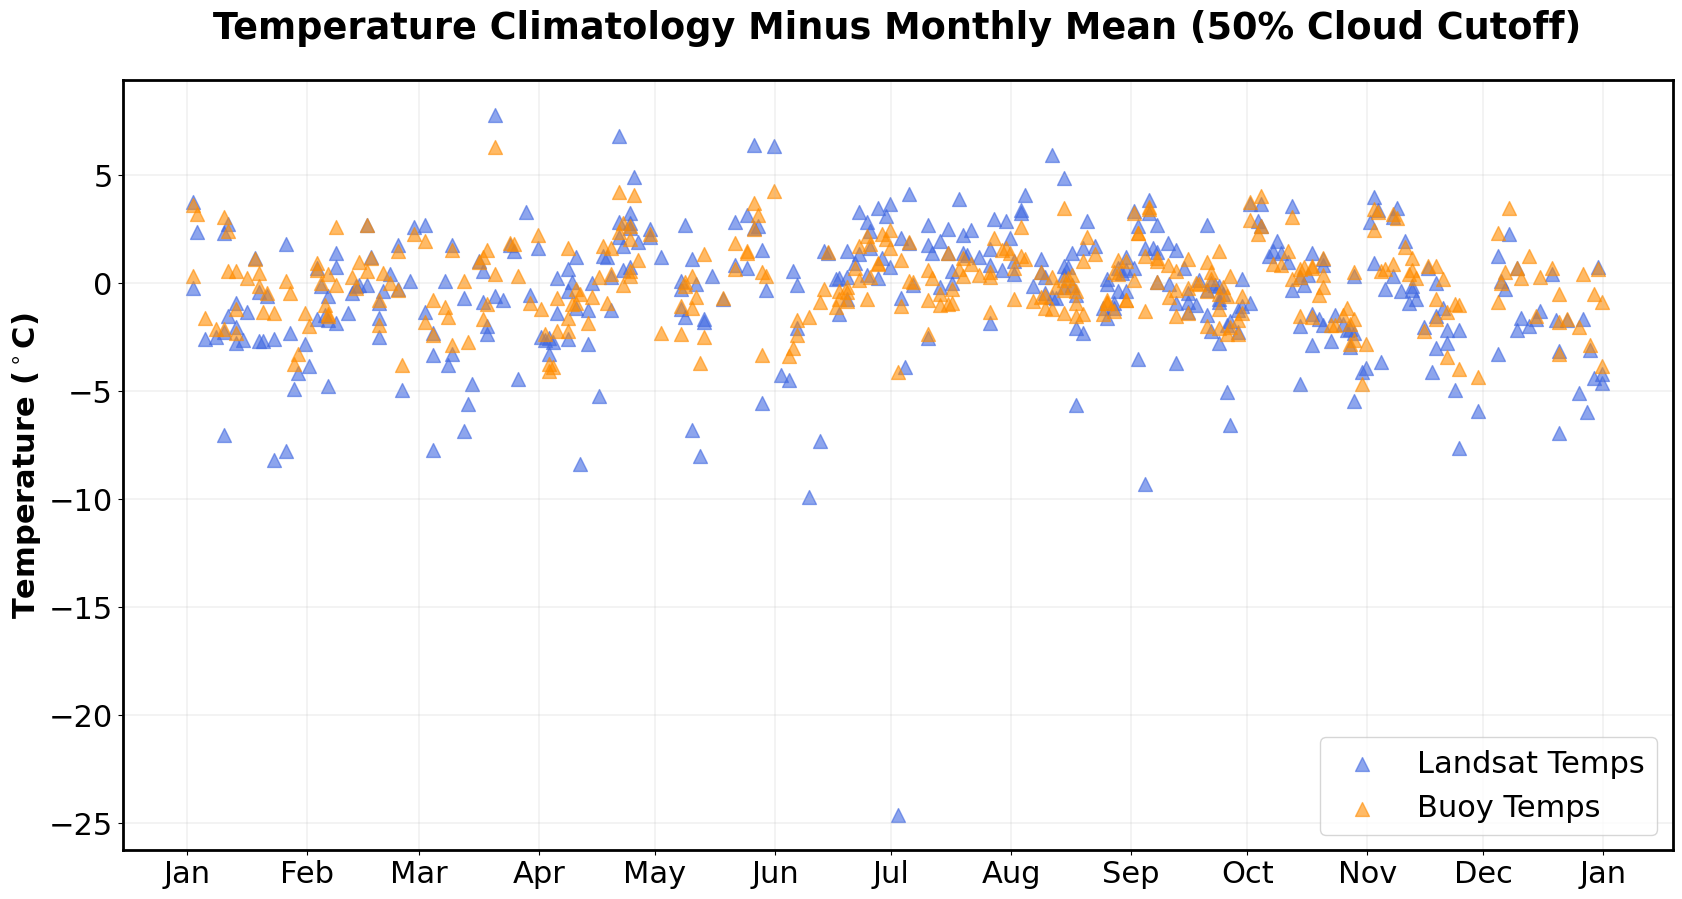

In [67]:
#@title Climatology Plot (Bias Calibrated)

### Plots a climatology of Landsat and buoy temperature data, with lines
### of best fit ###

# Updates plotting parameters #
plt.rcParams.update({'font.size': 22})
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["axes.titleweight"] = "bold"
plt.rcParams['axes.linewidth'] = 2

# Creates arrays that will be filled with datetime objects for plotting #
L5datesTick = np.empty(len(L5dates_filtered), dtype=dt)
L7datesTick = np.empty(len(L7dates_filtered), dtype=dt)
L8datesTick = np.empty(len(L8dates_filtered), dtype=dt)

# Fills arrays created above with datetime objects #
for i in range(len(L5dates_filtered)):
  L5datesTick[i] = dt.strptime("2000" + L5dates_filtered[i][4:10] + " " + L5dates_filtered[i][11:19], '%Y-%m-%d %H:%M:%S')
for i in range(len(L7dates_filtered)):
  L7datesTick[i] = dt.strptime("2000" + L7dates_filtered[i][4:10] + " " + L7dates_filtered[i][11:19], '%Y-%m-%d %H:%M:%S')
for i in range(len(L8dates_filtered)):
  L8datesTick[i] = dt.strptime("2000" + L8dates_filtered[i][4:10] + " " + L8dates_filtered[i][11:19], '%Y-%m-%d %H:%M:%S')

# Arrays used to find the monthly means for Landsat and buoy temperatures #
months = ["01","02","03","04","05","06","07","08","09","10","11","12"]
dates = [dt(2000,1,15),dt(2000,2,15),dt(2000,3,15),dt(2000,4,15),
         dt(2000,5,15),dt(2000,6,15),dt(2000,7,15),dt(2000,8,15),
         dt(2000,9,15),dt(2000,10,15),dt(2000,11,15),dt(2000,12,15)]
stamps = np.array([dt(2000,1,15).timestamp(), dt(2000,2,15).timestamp(),
                   dt(2000,3,15).timestamp(), dt(2000,4,15).timestamp(),
                   dt(2000,5,15).timestamp(), dt(2000,6,15).timestamp(),
                   dt(2000,7,15).timestamp(), dt(2000,8,15).timestamp(),
                   dt(2000,9,15).timestamp(), dt(2000,10,15).timestamp(),
                   dt(2000,11,15).timestamp(), dt(2000,12,15).timestamp()])

# Creates 12 empty lists (one list per month), that will be filled below #
L5monthAvg = [[] for Null in range(12)]
L7monthAvg = [[] for Null in range(12)]
L8monthAvg = [[] for Null in range(12)]
BuoyMonthAvgL5 = [[] for Null in range(12)]
BuoyMonthAvgL7 = [[] for Null in range(12)]
BuoyMonthAvgL8 = [[] for Null in range(12)]

# Loops through each filtered dates array and fills the above arrays with
# temperature values based on month #
for i in range(len(L5dates_filtered)):
  month = str(L5dates_filtered[i])[5:7]
  L5monthAvg[months.index(month)].append(np.nanmean(L5temps_landsat_calibrated[:,i]))
  BuoyMonthAvgL5[months.index(month)].append(np.nanmean(L5temps_buoy_filtered[:,i]))
for i in range(len(L7dates_filtered)):
  month = str(L7dates_filtered[i])[5:7]
  L7monthAvg[months.index(month)].append(np.nanmean(L7temps_landsat_calibrated[:,i]))
  BuoyMonthAvgL7[months.index(month)].append(np.nanmean(L7temps_buoy_filtered[:,i]))
for i in range(len(L8dates_filtered)):
  month = str(L8dates_filtered[i])[5:7]
  L8monthAvg[months.index(month)].append(np.nanmean(L8temps_landsat_calibrated[:,i]))
  BuoyMonthAvgL8[months.index(month)].append(np.nanmean(L8temps_buoy_filtered[:,i]))

# Calculates the mean temperature for each month #
L578monthAvg = np.empty(12)*np.nan
BuoyMonthAvgL578 = np.empty(12)*np.nan
for i in range(len(months)):
  L5monthAvg[i] = np.nanmean(np.array(L5monthAvg[i]))
  L7monthAvg[i] = np.nanmean(np.array(L7monthAvg[i]))
  L8monthAvg[i] = np.nanmean(np.array(L8monthAvg[i]))
  L578monthAvg[i] = np.nanmean(np.array([L5monthAvg[i], L7monthAvg[i], L8monthAvg[i]]))
  BuoyMonthAvgL5[i] = np.nanmean(np.array(BuoyMonthAvgL5[i]))
  BuoyMonthAvgL7[i] = np.nanmean(np.array(BuoyMonthAvgL7[i]))
  BuoyMonthAvgL8[i] = np.nanmean(np.array(BuoyMonthAvgL8[i]))
  BuoyMonthAvgL578[i] = np.nanmean(np.array([BuoyMonthAvgL5[i], BuoyMonthAvgL7[i], BuoyMonthAvgL8[i]]))

# Line of best fit, sets initial parameters and creates function #
def test_func(t, T0, delta_T, tau, phi):
    return T0 + (delta_T / 2) * np.sin(2 * np.pi * t / tau + phi)
T0 = 20
delta_T = 35
tau = 365*24*3600
phi = 2*np.pi*4*30.5*3600/tau
landsat_params, landsat_params_covariance = optimize.curve_fit(test_func, stamps, L578monthAvg, p0=[T0, delta_T, tau, phi])
buoy_params, buoy_params_covariance = optimize.curve_fit(test_func, stamps, BuoyMonthAvgL578, p0=[T0, delta_T, tau, phi])

# Vectorizes a function that converts timestamp to datetime #
def convertTime(timestamp):
  return(dt.fromtimestamp(timestamp))
convertTimeVectorized = np.vectorize(convertTime)

# Interpolates the line of best fit to make smooth curve #
landsat_spline = make_interp_spline(stamps, test_func(stamps, landsat_params[0], landsat_params[1], landsat_params[2], landsat_params[3]))
buoy_spline = make_interp_spline(stamps, test_func(stamps, buoy_params[0], buoy_params[1], buoy_params[2], buoy_params[3]))
stamps_spline = np.linspace(stamps.min(), stamps.max(), 500)
dates_spline = convertTimeVectorized(stamps_spline)
landsat_temps_spline = landsat_spline(stamps_spline)
buoy_temps_spline = buoy_spline(stamps_spline)

allDatesTick = np.concatenate((L5datesTick, L7datesTick, L8datesTick), 0)
allLandsatData = np.concatenate((L5temps_landsat_calibrated, L7temps_landsat_calibrated, L8temps_landsat_calibrated), 1)
allBuoyData = np.concatenate((L5temps_buoy_filtered, L7temps_buoy_filtered, L8temps_buoy_filtered), 1)
for i in range(len(allDatesTick)):
  month = str(allDatesTick[i])[5:7]
  index = months.index(month)
  allLandsatData[:,i] = allLandsatData[:,i] - BuoyMonthAvgL578[index]
  allBuoyData[:,i] = allBuoyData[:,i] - BuoyMonthAvgL578[index]

# Plots the Landsat and buoy temperatures over one year (averaged by buoy), as
# well as two lines of best fit for the Landsat and buoy temperatures #
fig, ax = plt.subplots(figsize = [20, 10])
ax.scatter(allDatesTick, np.nanmean(allLandsatData, 0), marker = '^', c="royalblue", alpha=0.6, s=100)
ax.scatter(allDatesTick, np.nanmean(allBuoyData, 0), marker = '^', c="darkorange", alpha=0.6, s=100)
legend = ax.legend(["Landsat Temps", "Buoy Temps"], loc = "lower right")
plt.title("Temperature Climatology Minus Monthly Mean (" + str(cloud_cutoff) + "% Cloud Cutoff)", pad=30)
plt.ylabel("Temperature ($^\circ$C)")
date_form = DateFormatter("%b")
ax.xaxis.set_major_formatter(date_form)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
ax.grid(lw=0.2)
plt.show()

np.savetxt("all_dates.csv", allDatesTick, delimiter=",", fmt='%s')
np.savetxt("all_landsat_data.csv", allLandsatData, delimiter=",")
np.savetxt("all_buoy_data.csv", allBuoyData, delimiter=",")
np.savetxt("monthly_averages.csv", BuoyMonthAvgL578, delimiter=",")

# Preliminary Results

In [68]:
### Function that reads csv files ###

def readCSV(fpath):
  file = open(fpath + ".csv")
  csvreader = csv.reader(file)
  array = []
  for row in csvreader:
    array.append(row)
  return np.array(array)

In [ ]:
### Takes the average scene temperature for both the entire Narragansett Bay
### and Mt. Hope Bay, for every Landsat scene, and saves the averages
### to the drive ###

locations = ["bay", "brayton"]
for i in range(len(locations)):
  fpath = '/content/drive/MyDrive/SURF_UG/Dan_Lorenzo_Ashfaq/polished_notebooks/csv_images/'
  dates = np.squeeze(readCSV(fpath + "dates"), 1)
  spatial_averages = np.empty(len(dates)) * np.nan
  for j in range(len(dates)):
    print(str(j) + " of " + str(len(dates)))
    image = np.array(readCSV(fpath + locations[i] + "/" + dates[j])).astype(float)
    spatial_averages[j] = np.nanmean(image)
  %cd '/content/drive/MyDrive/SURF_UG/Dan_Lorenzo_Ashfaq/all_temp_data/csv_images/'
  np.savetxt("avg_" + locations[i] + "_temps.csv", spatial_averages, delimiter=",")

In [ ]:
### Loads the average scene temperature arrays from the drive and filters by
### cloud cutoff ###

fpath = '/content/drive/MyDrive/SURF_UG/Dan_Lorenzo_Ashfaq/polished_notebooks/csv_images/'
all_dates = np.squeeze(readCSV(fpath + "dates"), 1)
clouds = np.squeeze(readCSV(fpath + "clouds"), 1).astype(float)
bay_averages = np.squeeze(readCSV(fpath + "avg_bay_temps"), 1).astype(float)
brayton_averages = np.squeeze(readCSV(fpath + "avg_brayton_temps"), 1).astype(float)

cloud_cutoff = 50
all_dates = all_dates[np.nonzero(clouds < cloud_cutoff)]
bay_averages = bay_averages[np.nonzero(clouds < cloud_cutoff)]
brayton_averages = brayton_averages[np.nonzero(clouds < cloud_cutoff)]

bay_dates = all_dates[~np.isnan(bay_averages)]
brayton_dates = all_dates[~np.isnan(brayton_averages)]
bay_averages = bay_averages[~np.isnan(bay_averages)]
brayton_averages = brayton_averages[~np.isnan(brayton_averages)]

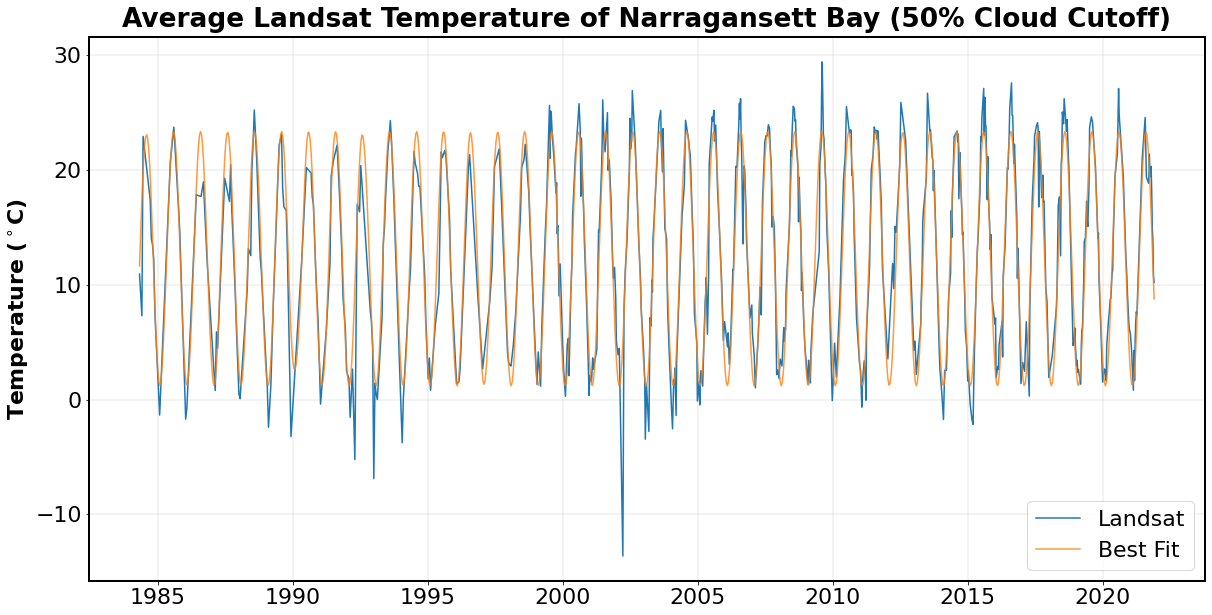

In [ ]:
#@title Average Landsat Temperature Plot (bias calibrated)

### Plots the average Landsat scene temperature over time, with a sinusoidal
### line of best fit ###

# Updates plotting parameters #
plt.rcParams.update({'font.size': 22})
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["axes.titleweight"] = "bold"
plt.rcParams['axes.linewidth'] = 2

# Builds a flexible framework for switching between Narragansett Bay and
# Mt. Hope Bay, switch "index" to 0 or 1 depending on desired region #
index = 0
location = ["Narragansett Bay", "Mt. Hope Bay"]
averages = [bay_averages, brayton_averages]
dates = [bay_dates, brayton_dates]
datetimes = np.empty(len(dates[index]), dtype = dt)
for i in range(len(dates[index])):
  datetimes[i] = dt.strptime(dates[index][i], '%Y-%m-%d')
average = averages[index]

# Function for converting datetime to timestamp
def convert_date2stamp(date):
  return (dt.timestamp(date))
convert_date2stamp_vec = np.vectorize(convert_date2stamp)

# Function for converting timestamp to datetime
def convert_stamp2date(stamp):
  return (dt.fromtimestamp(stamp))
convert_stamp2date_vec = np.vectorize(convert_stamp2date)

# Creates timestamp array from datetime array
stamps_sorted = convert_date2stamp_vec(datetimes)

# Defines line of best fit
def best_fit(t, T0, delta_T, tau, phi):
    return T0 + (delta_T / 2) * np.sin(2 * np.pi * t / tau + phi)
T0 = 20
delta_T = 35
tau = 365*24*3600
phi = 2*np.pi*4*30.5*3600/tau
params, params_covariance = optimize.curve_fit(best_fit, stamps_sorted, average, p0=[T0, delta_T, tau, phi])

# Interpolation for smoother line of best fit
averages_spline = make_interp_spline(stamps_sorted, best_fit(stamps_sorted, params[0], params[1], params[2], params[3]))
stamps_spline = np.linspace(stamps_sorted.min(), stamps_sorted.max(), 1000)
datetimes_spline = convert_stamp2date_vec(stamps_spline)
averages_spline_plot = averages_spline(stamps_spline)

# Plots the data
fig, ax = plt.subplots(figsize = [20, 10])
ax.plot(datetimes, average)
ax.plot(datetimes_spline, averages_spline_plot, alpha = 0.8)
ax.grid(lw=0.3)
ax.set_ylabel("Temperature ($^\circ$C)");
ax.set_title("Average Landsat Temperature of " + location[index] + " (" + str(cloud_cutoff) + "% Cloud Cutoff)", pad = 10);
ax.legend(["Landsat", "Best Fit"], loc = "lower right");
ax.grid(lw=0.3)

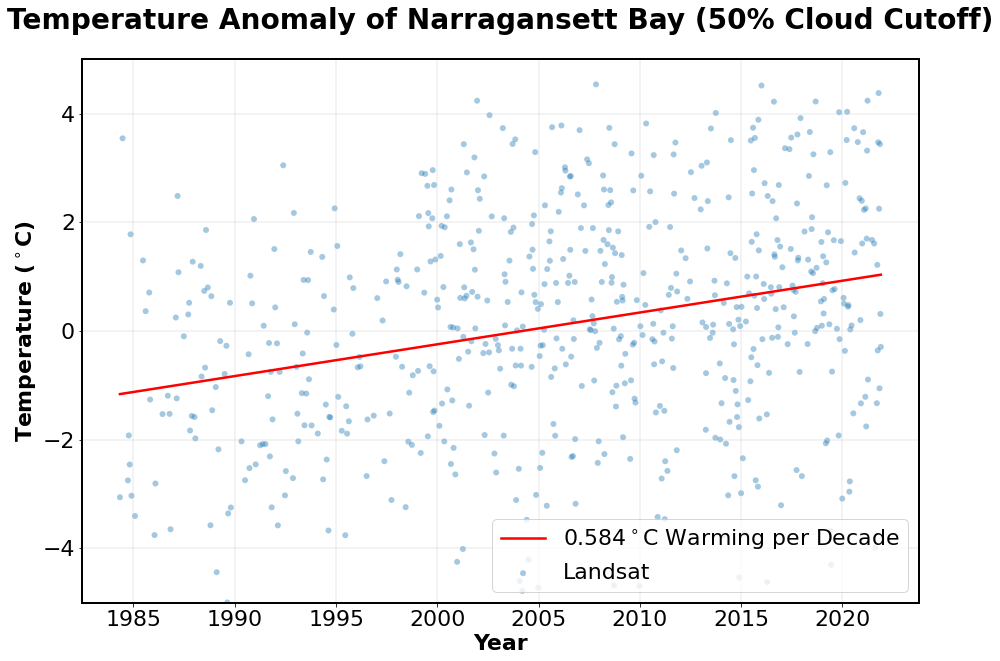

In [ ]:
#@title Landsat Temperature Anomaly Plot (bias calibrated)

### Plots the temperature anomaly of region, removes seaonal cycle ###

# Updates plotting parameters #
plt.rcParams.update({'font.size': 22})
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["axes.titleweight"] = "bold"
plt.rcParams['axes.linewidth'] = 2

# Builds a flexible framework for switching between Narragansett Bay and
# Mt. Hope Bay, switch "index" to 0 or 1 depending on desired region #
index = 0
location = ["Narragansett Bay", "Mt. Hope Bay"]
averages = [bay_averages, brayton_averages]
dates = [bay_dates, brayton_dates]
datetimes = np.empty(len(dates[index]), dtype = dt)
for i in range(len(dates[index])):
  datetimes[i] = dt.strptime(dates[index][i], '%Y-%m-%d')
average = averages[index]
# datetimes = datetimes[260:]
# average = average[260:]

# Creates arrays that will be used to store monthly averages #
months = ["01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "11", "12"]
monthly_data = [[] for Null in range(12)]
monthly_averages = np.empty(12) * np.nan
anomaly = np.empty(len(average)) * np.nan

# Fills arrays above with monthly temperature averages, removes monthly
# average temperature from all datapoints #
for i in range(len(datetimes)):
  month = str(datetimes[i])[5:7]
  monthly_data[months.index(month)].append(average[i])
for i in range(len(months)):
  monthly_averages[i] = np.mean(np.array(monthly_data[i]))
for i in range(len(datetimes)):
  month = str(datetimes[i])[5:7]
  anomaly[i] = average[i] - monthly_averages[months.index(month)]

# Finds the mean and std of the dataset and throws away outlying points #
mean = np.mean(anomaly)
std = np.std(anomaly)
coef = 2.5
datetimes = datetimes[anomaly > mean-coef*std]
anomaly = anomaly[anomaly > mean-coef*std]
datetimes = datetimes[anomaly < mean+coef*std]
anomaly = anomaly[anomaly < mean+coef*std]

# Function that converts datetime to timestamp#
def convert_date2stamp(date):
  return (dt.timestamp(date))
convert_date2stamp_vec = np.vectorize(convert_date2stamp)
timestamps_sorted = convert_date2stamp_vec(datetimes)

# Line of best fit #
def linear_fit(t, m, b):
    return m * t + b
m = 5/365*24*3600
b = 0
params, params_covariance = optimize.curve_fit(linear_fit, timestamps_sorted, anomaly, p0=[m, b])

# Plots the data #
fig, ax = plt.subplots(figsize = [15, 10])
ax.scatter(datetimes, anomaly, alpha = 0.4, edgecolors= 'none')
ax.plot(datetimes, linear_fit(timestamps_sorted, params[0], params[1]), color = "red", lw=2.5)
ax.set_xlabel("Year")
ax.set_ylabel("Temperature ($^\circ$C)");
ax.set_title("Temperature Anomaly of " + location[index] + " (" + str(cloud_cutoff) + "% Cloud Cutoff)", pad = 30, fontdict={'fontsize': 28});
ax.legend([str(round(params[0]*315400000, 3)) + "$^\circ$C Warming per Decade", "Landsat"], loc = "lower right");
ax.set_ylim([-5,5]);
ax.grid(lw=0.3)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: Mean of empty slice
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: Mean of empty slice
  


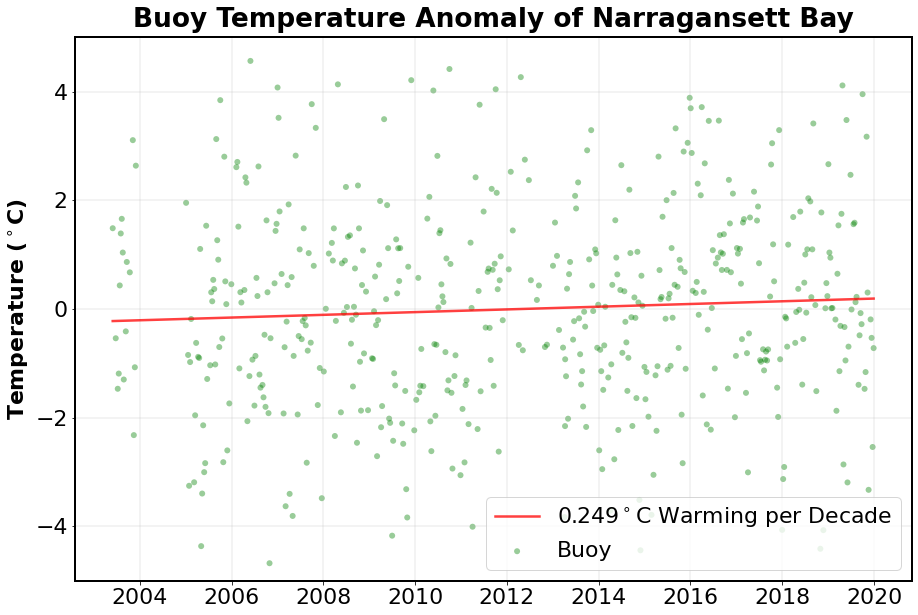

In [ ]:
#@title Buoy Temperature Anomaly Plot

### Plots the temperature anomaly of region, removes seaonal cycle ###

# Updates plotting parameters #
plt.rcParams.update({'font.size': 22})
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["axes.titleweight"] = "bold"
plt.rcParams['axes.linewidth'] = 2

# Loads buoy data #
fpath = '/content/drive/MyDrive/SURF_UG/Dan_Lorenzo_Ashfaq/polished_notebooks/buoy_data/'
L5buoy = np.nanmean(readCSV(fpath + "L5BuoyData").astype(float), 0)
L7buoy = np.nanmean(readCSV(fpath + "L7BuoyData").astype(float), 0)
L8buoy = np.nanmean(readCSV(fpath + "L8BuoyData").astype(float), 0)
buoy = np.concatenate((L5buoy, L7buoy, L8buoy))
fpath = '/content/drive/MyDrive/SURF_UG/Dan_Lorenzo_Ashfaq/polished_notebooks/dates_clouds/'
L5dates = np.squeeze(readCSV(fpath + "L5dates"), 1)
L7dates = np.squeeze(readCSV(fpath + "L7dates"), 1)
L8dates = np.squeeze(readCSV(fpath + "L8dates"), 1)
dates = np.concatenate((L5dates, L7dates, L8dates))
datetimes = np.empty(len(dates), dtype = dt)
for i in range(len(dates)):
  datetimes[i] = dt.strptime(dates[i][:10], '%Y-%m-%d')
sorting_indices = np.argsort(datetimes)
datetimes_sorted = datetimes[sorting_indices]
buoy_sorted = buoy[sorting_indices]
datetimes_sorted = datetimes_sorted[~np.isnan(buoy_sorted)]
buoy_sorted = buoy_sorted[~np.isnan(buoy_sorted)]

# Creates arrays that will be used to store monthly averages #
months = ["01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "11", "12"]
monthly_data = [[] for Null in range(12)]
monthly_averages = np.empty(12) * np.nan
anomaly_sorted = np.empty(len(buoy_sorted)) * np.nan

# Fills arrays above with monthly temperature averages, removes monthly
# average temperature from all datapoints #
for i in range(len(datetimes_sorted)):
  month = str(datetimes_sorted[i])[5:7]
  monthly_data[months.index(month)].append(buoy_sorted[i])
for i in range(len(months)):
  monthly_averages[i] = np.mean(np.array(monthly_data[i]))
for i in range(len(datetimes_sorted)):
  month = str(datetimes_sorted[i])[5:7]
  anomaly_sorted[i] = buoy_sorted[i] - monthly_averages[months.index(month)]

# Function that converts datetime to timestamp #
def convert_date2stamp(date):
  return (dt.timestamp(date))
convert_date2stamp_vec = np.vectorize(convert_date2stamp)
timestamps_sorted = convert_date2stamp_vec(datetimes_sorted)

# Line of best fit #
def linear_fit(t, m, b):
    return m * t + b
m = 5/365*24*3600
b = 0
params, params_covariance = optimize.curve_fit(linear_fit, timestamps_sorted, anomaly_sorted, p0=[m, b])

# Plots the data #
fig, ax = plt.subplots(figsize = [15, 10])
ax.scatter(datetimes_sorted, anomaly_sorted, color = "green", alpha = 0.4, edgecolors = 'none')
ax.plot(datetimes_sorted, linear_fit(timestamps_sorted, params[0], params[1]), color = "red", alpha = 0.75, lw=2.5)
ax.grid(lw=0.3)
ax.set_ylabel("Temperature ($^\circ$C)");
ax.set_title("Buoy Temperature Anomaly of Narragansett Bay", pad = 10);
ax.legend([str(round(params[0]*315400000, 3)) + "$^\circ$C Warming per Decade", "Buoy"], loc = "lower right");
ax.set_ylim([-5,5]);